In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import swarmplot
import os,itertools
import numpy as np
from IPython.display import HTML 
%matplotlib inline
import matplotlib as mpl


In [2]:
## OLD DATA
# fname = os.path.join(os.getcwd(),'../resources/accuracy_set.csv')
# df = pd.read_csv(fname, index_col=0, dtype={'input' : object, 'output': object}, error_bad_lines=False)
# drop_columns = ['Unnamed: 0', 'SynBioHub URI', 'Unnamed: 0.1', 'calibration_id', 'experiment_id', 'filename', 
#                 'glycerol_plate_index',  'growth_media_1', 'growth_media_2',  
#                 'inc_temp', 'inc_time_1', 'inc_time_2', 'input', 'lab', 'lab_id', 'media', 'od', 
#                 'od_cutoff', 'output', 'part_1_id', 'part_2_id', 'plate_id',  'replicate', 'source_container', 
#                 'strain_name', 'strain_circuit', 'well', 'post_well']
# od_df = pd.read_csv(os.path.join(os.getcwd(), '../resources/tx_od.csv')).rename(columns={'strain' : 'strain_name'}).drop(columns=drop_columns)
# df = df.merge(od_df, on='id', how='left')


# NEW DATA
fname = os.path.expanduser("~/sd2e-projects/sd2e-project-14/xplan-reactor/data/transcriptic/correctness/correctness.csv")
df = pd.read_csv(fname, index_col=0, dtype={'input' : object, 'output': object}, error_bad_lines=False)


discretization = [
          (0.0, 1e-4),
          (1e-4, 3e-4),
          (3e-4, 7e-4),
          (7e-4, 1e-3),
          (1e-3, 5.1e-3),
          (5.1e-3, 1.0)
      ]
means = [np.around(np.mean(d),5) for d in discretization]
means[-1] = 5.1e-3
recast = [means[i] for d in df["od"] for i,k in enumerate(discretization) if d > k[0] and d <= k[1] ]
df["od"] = recast

conditions=['inc_time_2', 'media', 'inc_temp', 'od']
design=['gate', 'input']


In [8]:
df.loc[df.lab_id == "r1c84y3r9yqxb_r1c8auwvzbgt3"].inc_temp.unique()

array([30.])

In [20]:
def strain_scores(correctness_col):
    strain_score_df = df.groupby(conditions+design)[correctness_col].agg(np.mean).reset_index()
    return strain_score_df
    

In [21]:
def hierarchical_means(correctness_col):
    strain_score_df = strain_scores(correctness_col)
    # Circuit x condition scores is product of strain for condition
    circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
    conditions2=['media', 'inc_temp', 'od']
    circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
    conditions3=['media', 'od']
    circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
    overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
    circuit_robustness_df.loc[:,"robustness"] = [1-c for c in circuit_robustness_df.loc[:,correctness_col]] 
    circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
    return circuit_score_df_prod,overall_circuit_score_df_prod,circuit_robustness_df
    

In [22]:
def hierarchical_means_2(correctness_col):
    strain_score_df = strain_scores(correctness_col)
    # Circuit x condition scores is product of strain for condition
    circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
    conditions2=['media', 'inc_temp', 'od']
    circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
    conditions3=['media', 'inc_temp']
    circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
    overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
    circuit_robustness_df.loc[:,"robustness"] = [1-c for c in circuit_robustness_df.loc[:,correctness_col]] 
    circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
    return circuit_score_df_prod,overall_circuit_score_df_prod,circuit_robustness_df
    

In [23]:
mpl.rcParams['figure.dpi']= 600

def get_vals(df_prod,correctness_col):
    data30_sc = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="standard_media")][correctness_col].values
    data30_osm = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data30_slow = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="slow_media")][correctness_col].values
    data37_sc = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="standard_media")][correctness_col].values
    data37_osm = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data37_slow = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="slow_media")][correctness_col].values
    return [data30_sc,data30_osm,data30_slow,data37_sc,data37_osm,data37_slow]


def calculate_stats(data):
    err = []
    medians = []
    stds = []
    for ds in data:
        s = np.std(ds)
        stds.append(s)
        err.append(s / np.sqrt(len(ds)))
        medians.append(np.median(ds))
    return err,stds,medians

# make error bar plots
def whisker(gate,correctness_col,df):
    plt.figure()
    df_prod = df[(df["gate"]==gate)]
    datasc=get_vals(df_prod,correctness_col)
    err,stds,medians = calculate_stats(datasc)
    print([z for z in zip(["SC30","OSM30","SLOW30","SC37","OSM37","SLOW37"],zip(stds,err))])
    plt.boxplot(datasc,patch_artist=True,boxprops=dict(facecolor="lightgray"))
    labels = list(y+"\n"+str(x) for x,y in itertools.product([30.0,37.0],["SC Media","High Osm","SC Slow"]))
    plt.xticks(range(1,7), labels, fontsize=10)
    plt.xlim((0.5,6.5))
    plt.ylim((-0.1,1))
    plt.ylabel("Correctness") 
    return medians
    

In [24]:
def make_all_dfs(correctness_columns):
    dfs = []
    for col in correctness_columns:
        print(col)
        df,overall_circuit_score_df_prod,circuit_robustness_df = hierarchical_means(col)
        dfs.append(df)
        display(HTML(overall_circuit_score_df_prod.sort_values(by=[col],ascending=False).to_html(index=False)))
        display(HTML(circuit_robustness_df.sort_values(by=['robustness'],ascending=False).to_html(index=False)))
    return dfs
        

In [25]:
def do_a_gate(gate,correctness_columns,dfs):
    medians = []
    for col,df in zip(correctness_columns,dfs):
        medians.append(whisker(gate,col,df))
    return medians

In [26]:
def compare_medians(col1,col2,cutoff):
    newcol1,newcol2 = [],[]
    for k,(c1,c2) in enumerate(zip(col1,col2)):
        if not np.isnan(c1) and not np.isnan(c2):
            newcol1.append(c1)
            newcol2.append(c2)
    lessthan = sum([m1-m2 >= cutoff for m1,m2 in zip(newcol1,newcol2)])/len(newcol1)
    greaterthan = sum([m1-m2 < 0 for m1,m2 in zip(newcol1,newcol2)])/len(newcol1)
    return lessthan,greaterthan

In [27]:
correctness_columns = ['mean_correct_classifier_live','mean_correct_threshold_live']
dfs = make_all_dfs(correctness_columns)


mean_correct_classifier_live


gate,mean_correct_classifier_live
AND,0.462371
NOR,0.380278
XNOR,0.262434
NAND,0.250861
XOR,0.172107
OR,0.030849


gate,robustness
XOR,0.965029
OR,0.949779
NAND,0.869455
XNOR,0.856020
NOR,0.843816
AND,0.772627


mean_correct_threshold_live


gate,mean_correct_threshold_live
AND,0.386436
XNOR,0.220296
NOR,0.206121
NAND,0.204194
XOR,0.114211
OR,0.046199


gate,robustness
XOR,0.947172
OR,0.944534
AND,0.916860
XNOR,0.905457
NOR,0.893371
NAND,0.876789


AND
[('SC30', (0.16238818763914792, 0.02916577948650976)), ('OSM30', (0.021955837879361364, 0.009818949200243367)), ('SLOW30', (0.0230145004622041, 0.01627370934244545)), ('SC37', (0.08421315867533724, 0.03766126947960604)), ('OSM37', (nan, nan)), ('SLOW37', (0.015161447529563568, 0.010720762360758427))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

[('SC30', (0.16209973068911784, 0.029113971088877883)), ('OSM30', (0.03141620181791841, 0.014049752571943607)), ('SLOW30', (0.024076121883664148, 0.01702438904861275)), ('SC37', (0.04150414780060487, 0.018561219166070175)), ('OSM37', (nan, nan)), ('SLOW37', (0.020297483615236367, 0.014352488305356475))]
Percent of threshold median at least 0.0 below classifier median: 0.6.
Percent of threshold median above classifier median: 0.4.


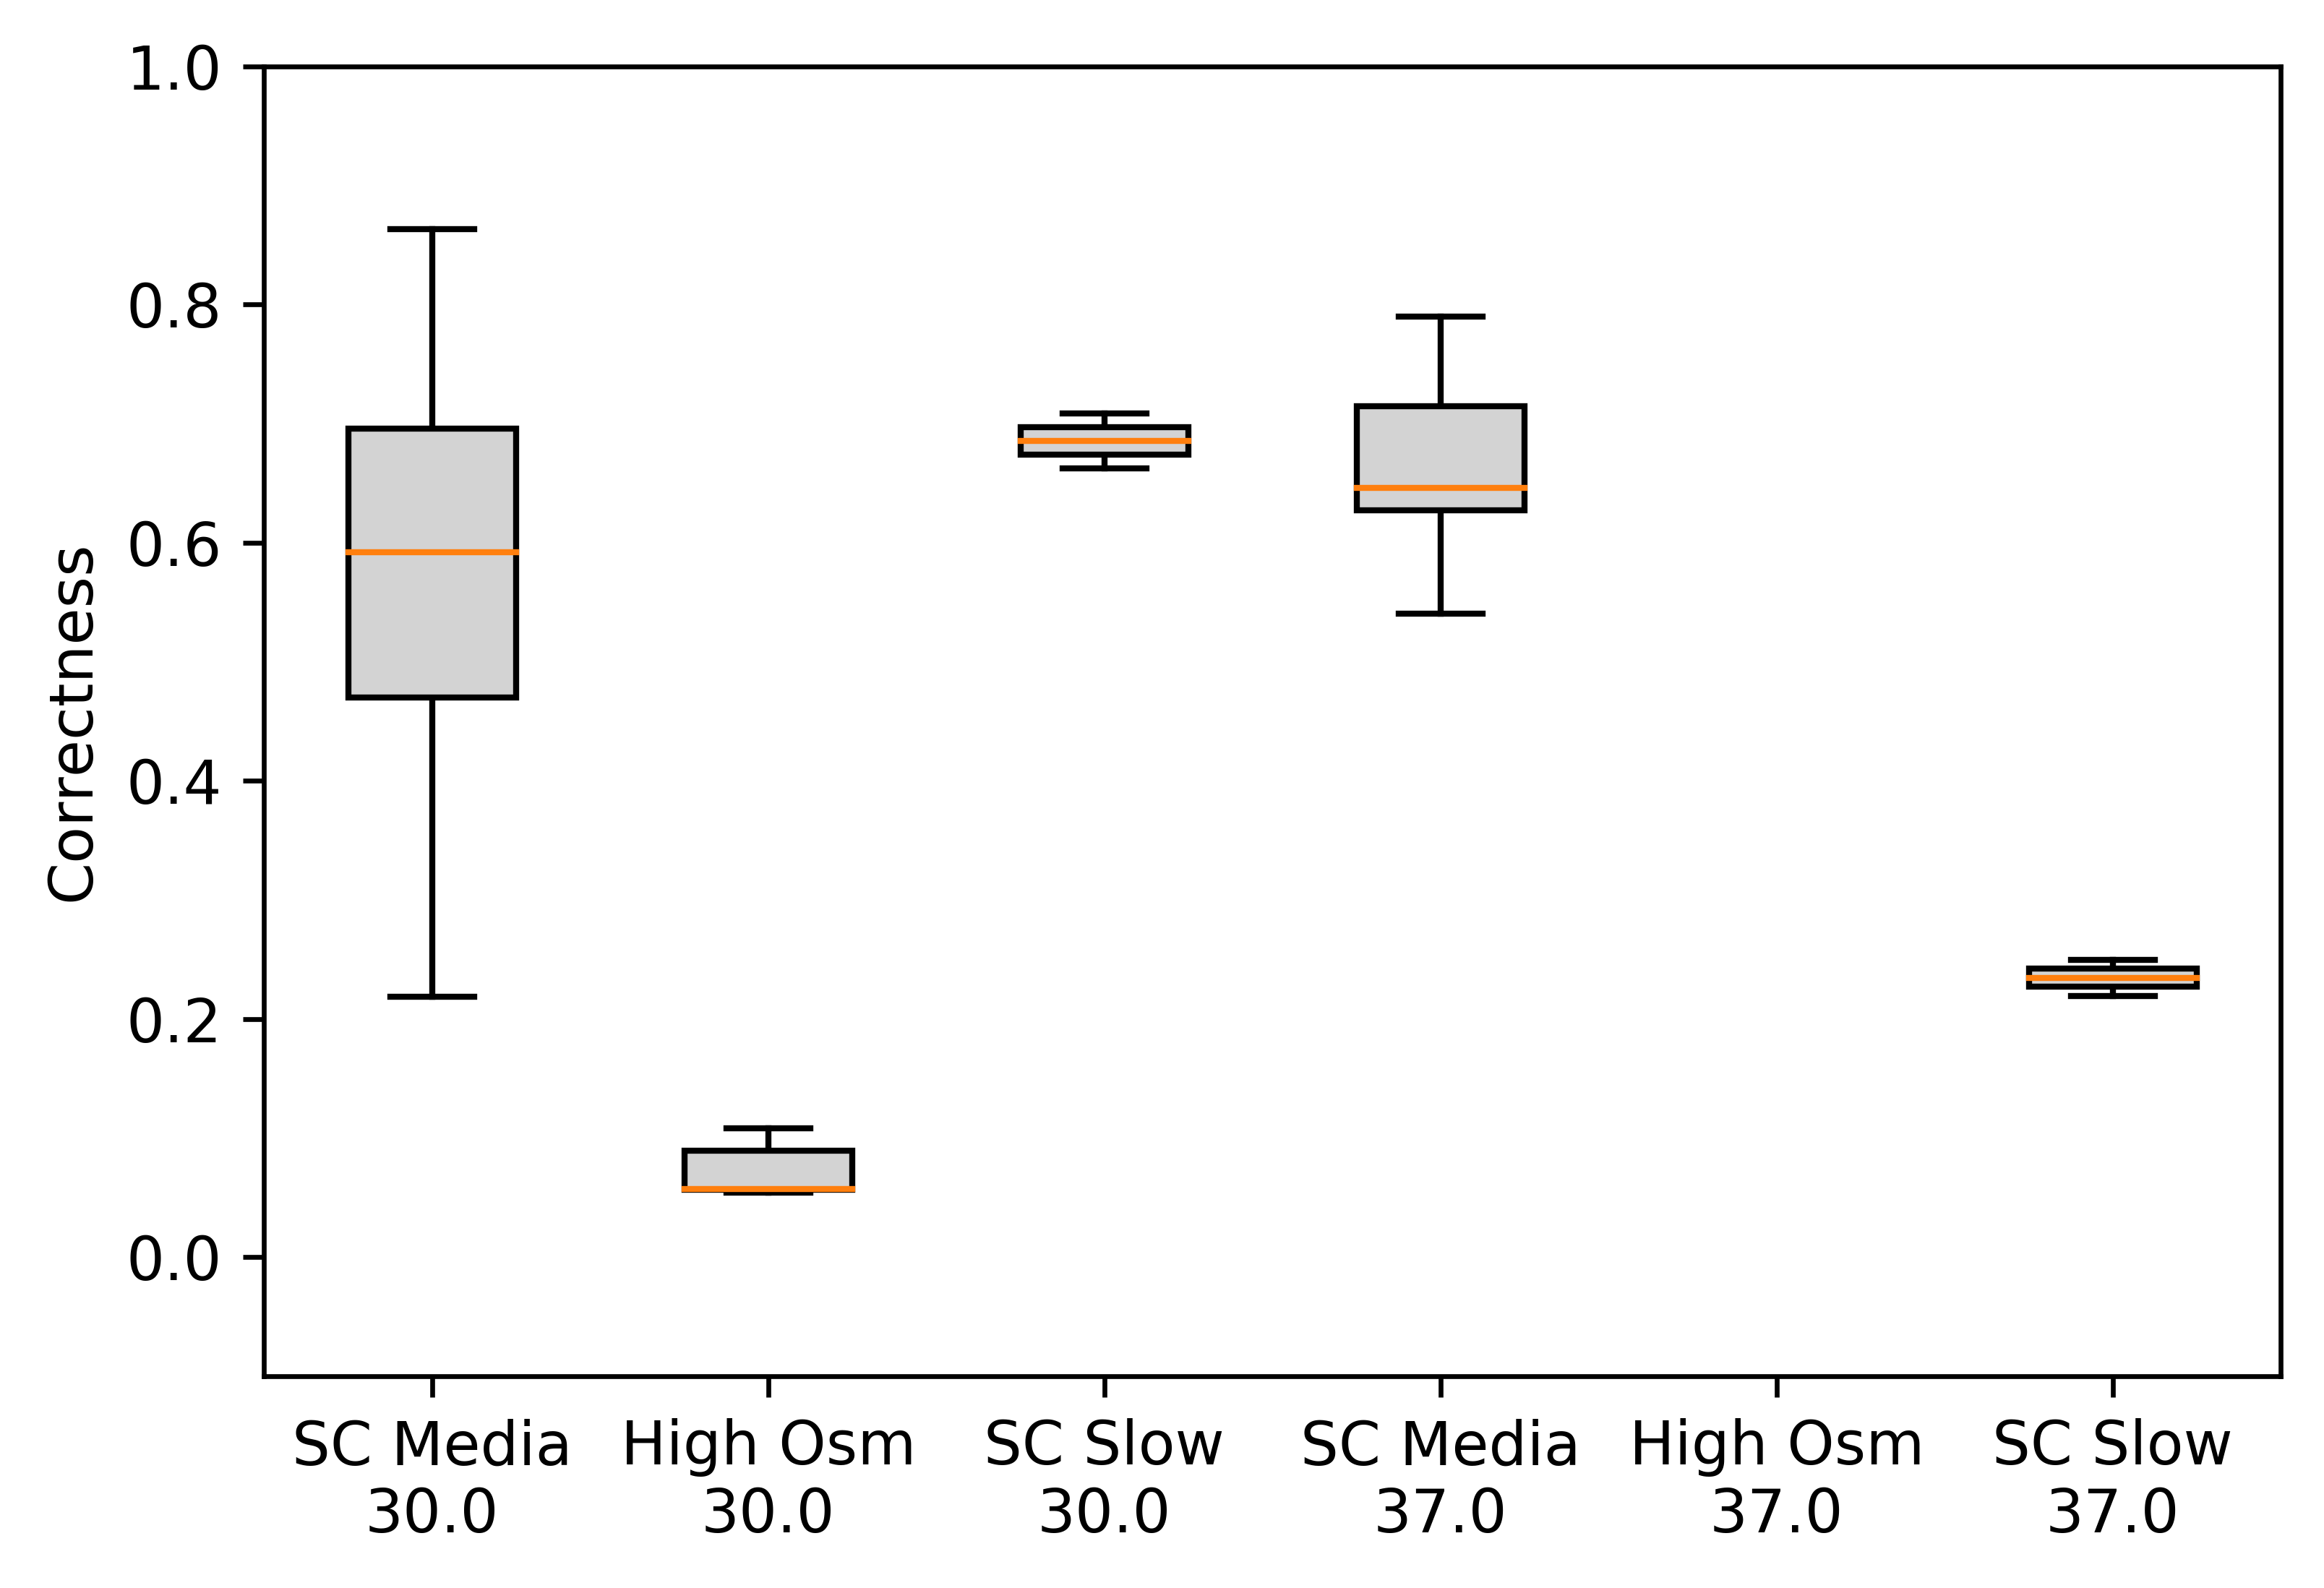

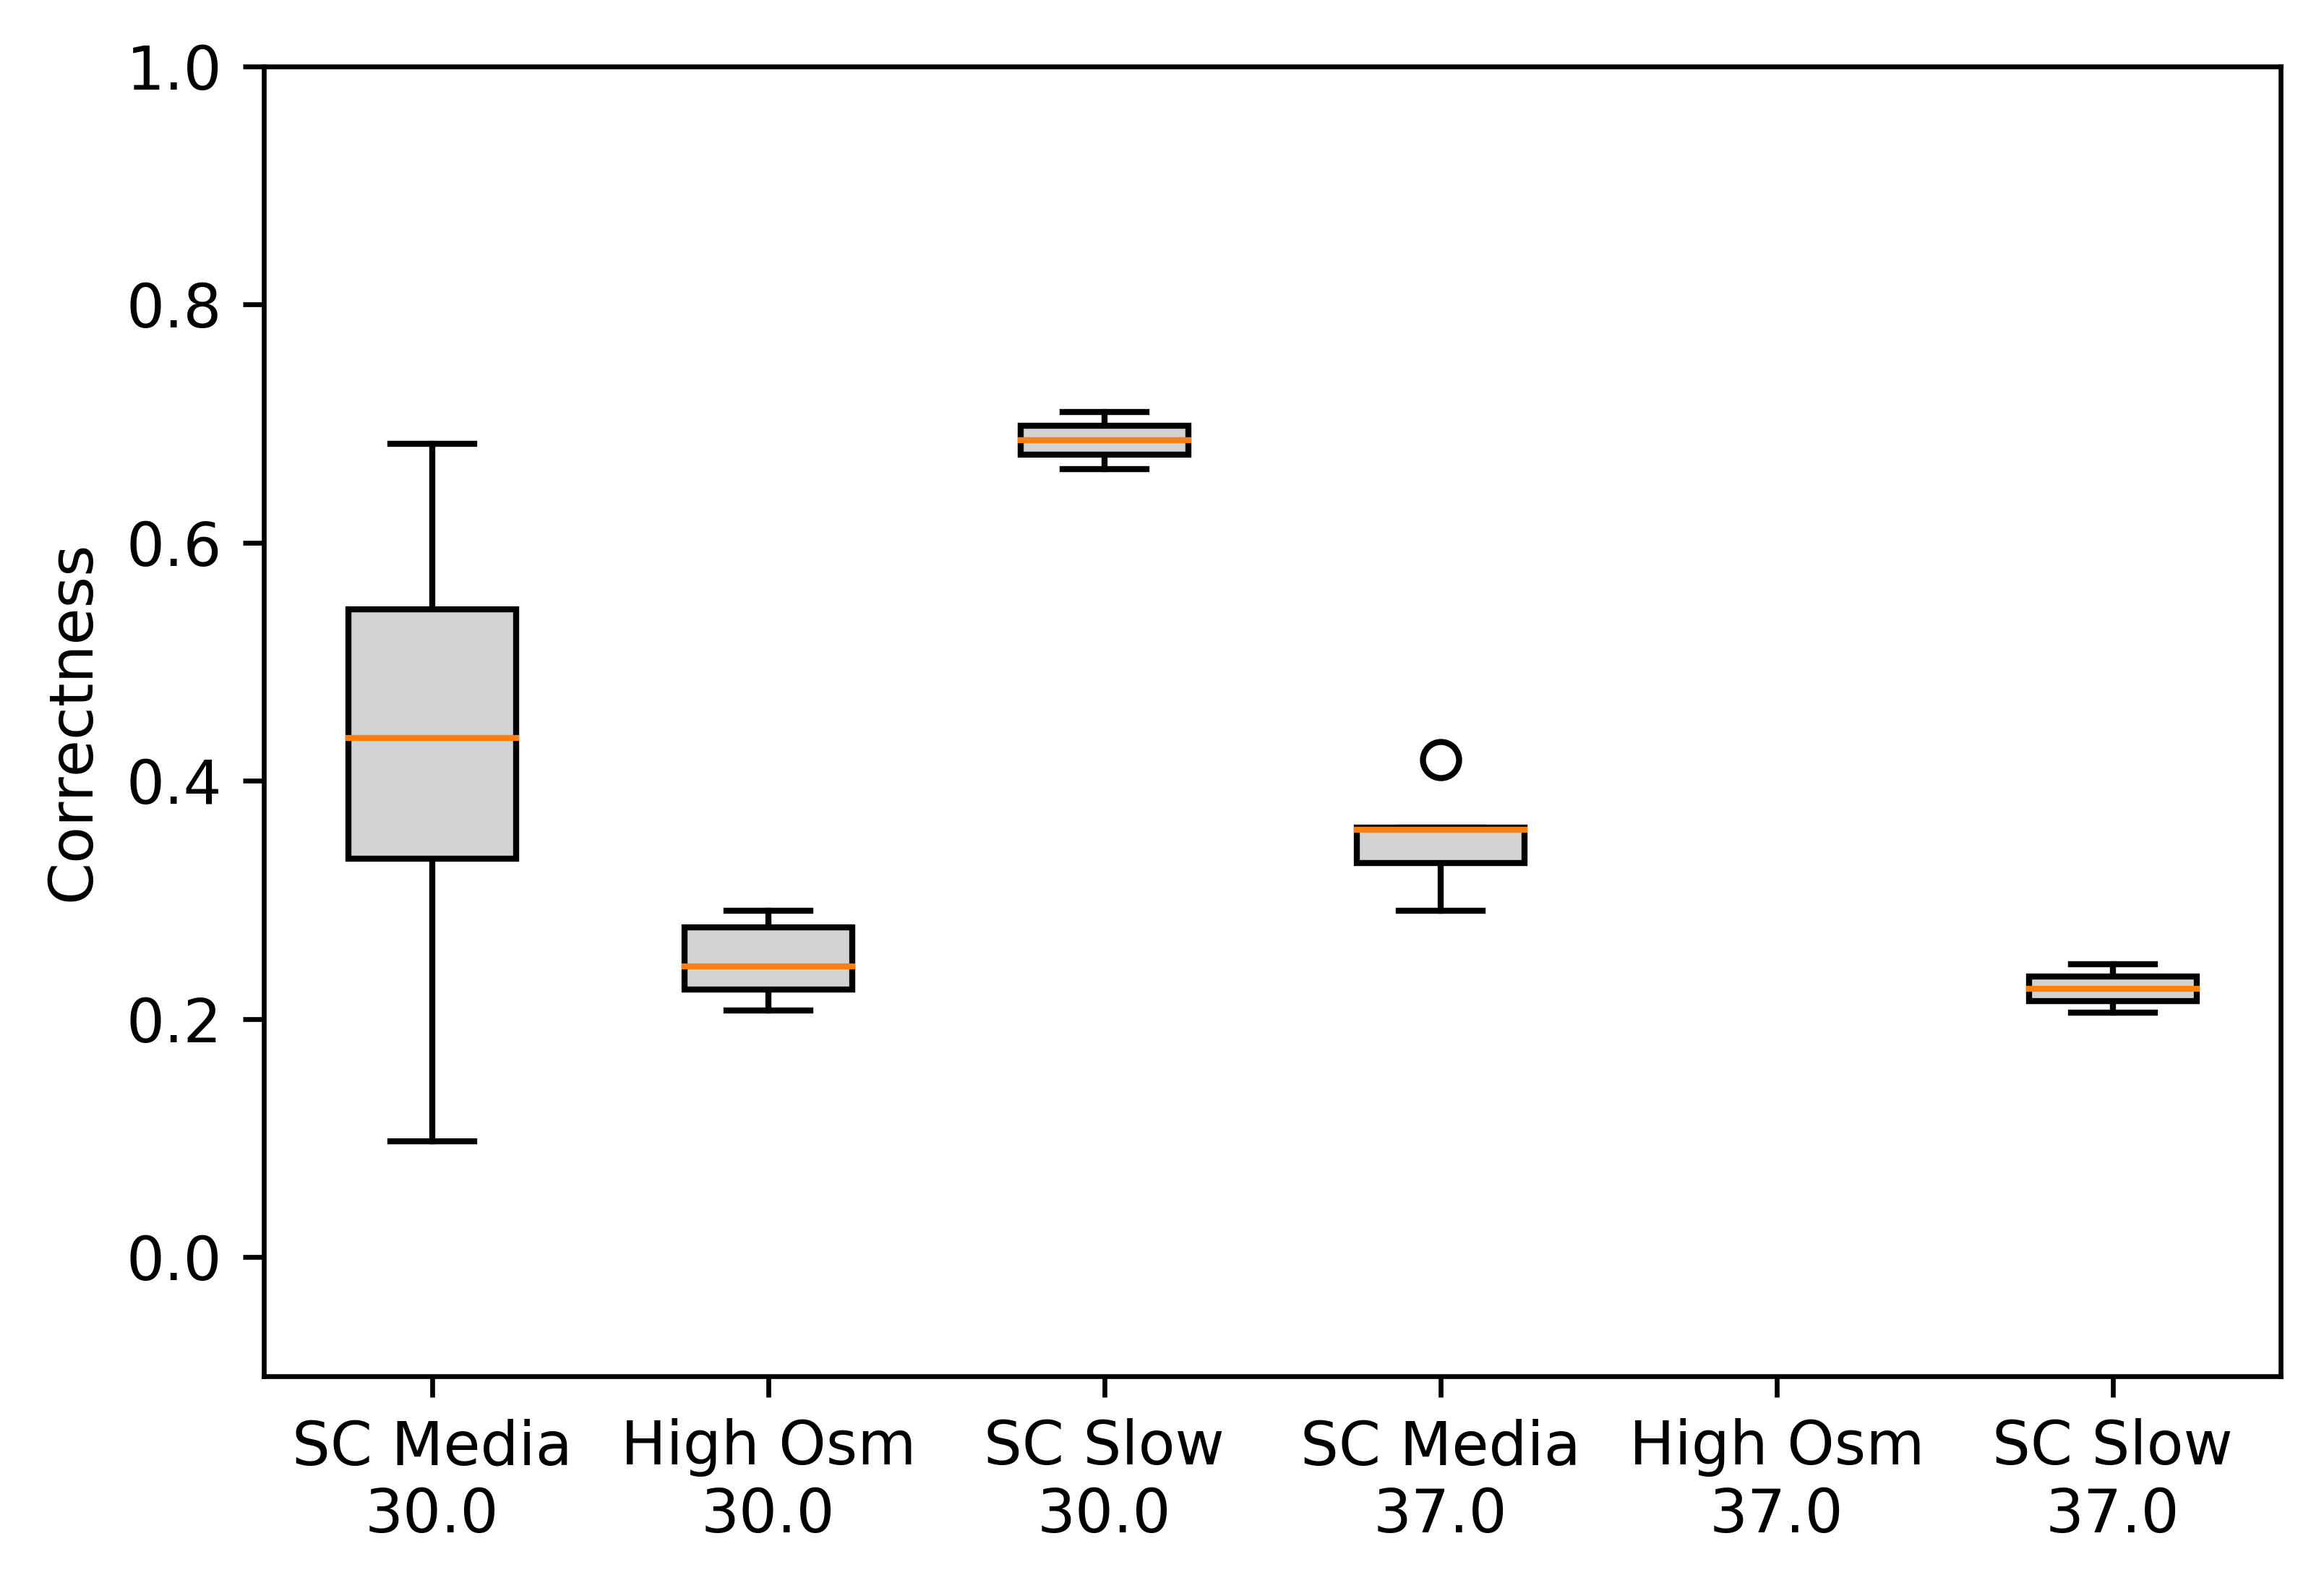

In [28]:
print("AND")
medians = do_a_gate("AND",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


NAND
[('SC30', (0.10220597825311512, 0.01835673559309273)), ('OSM30', (0.0186811099264531, 0.008354446338139044)), ('SLOW30', (0.013426161221789787, 0.00949372964523142)), ('SC37', (0.20514801682242456, 0.09174498221284234)), ('OSM37', (nan, nan)), ('SLOW37', (0.002296572978307057, 0.001623922326450706))]
[('SC30', (0.08771589805099594, 0.015754240361998923)), ('OSM30', (0.005670237994575614, 0.0025358075208946314)), ('SLOW30', (0.013066306482817147, 0.009239273919061751)), ('SC37', (0.08173958601024478, 0.03655505415431963)), ('OSM37', (nan, nan)), ('SLOW37', (0.011317860741493185, 0.008002936078834838))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

Percent of threshold median at least 0.0 below classifier median: 0.6.
Percent of threshold median above classifier median: 0.4.


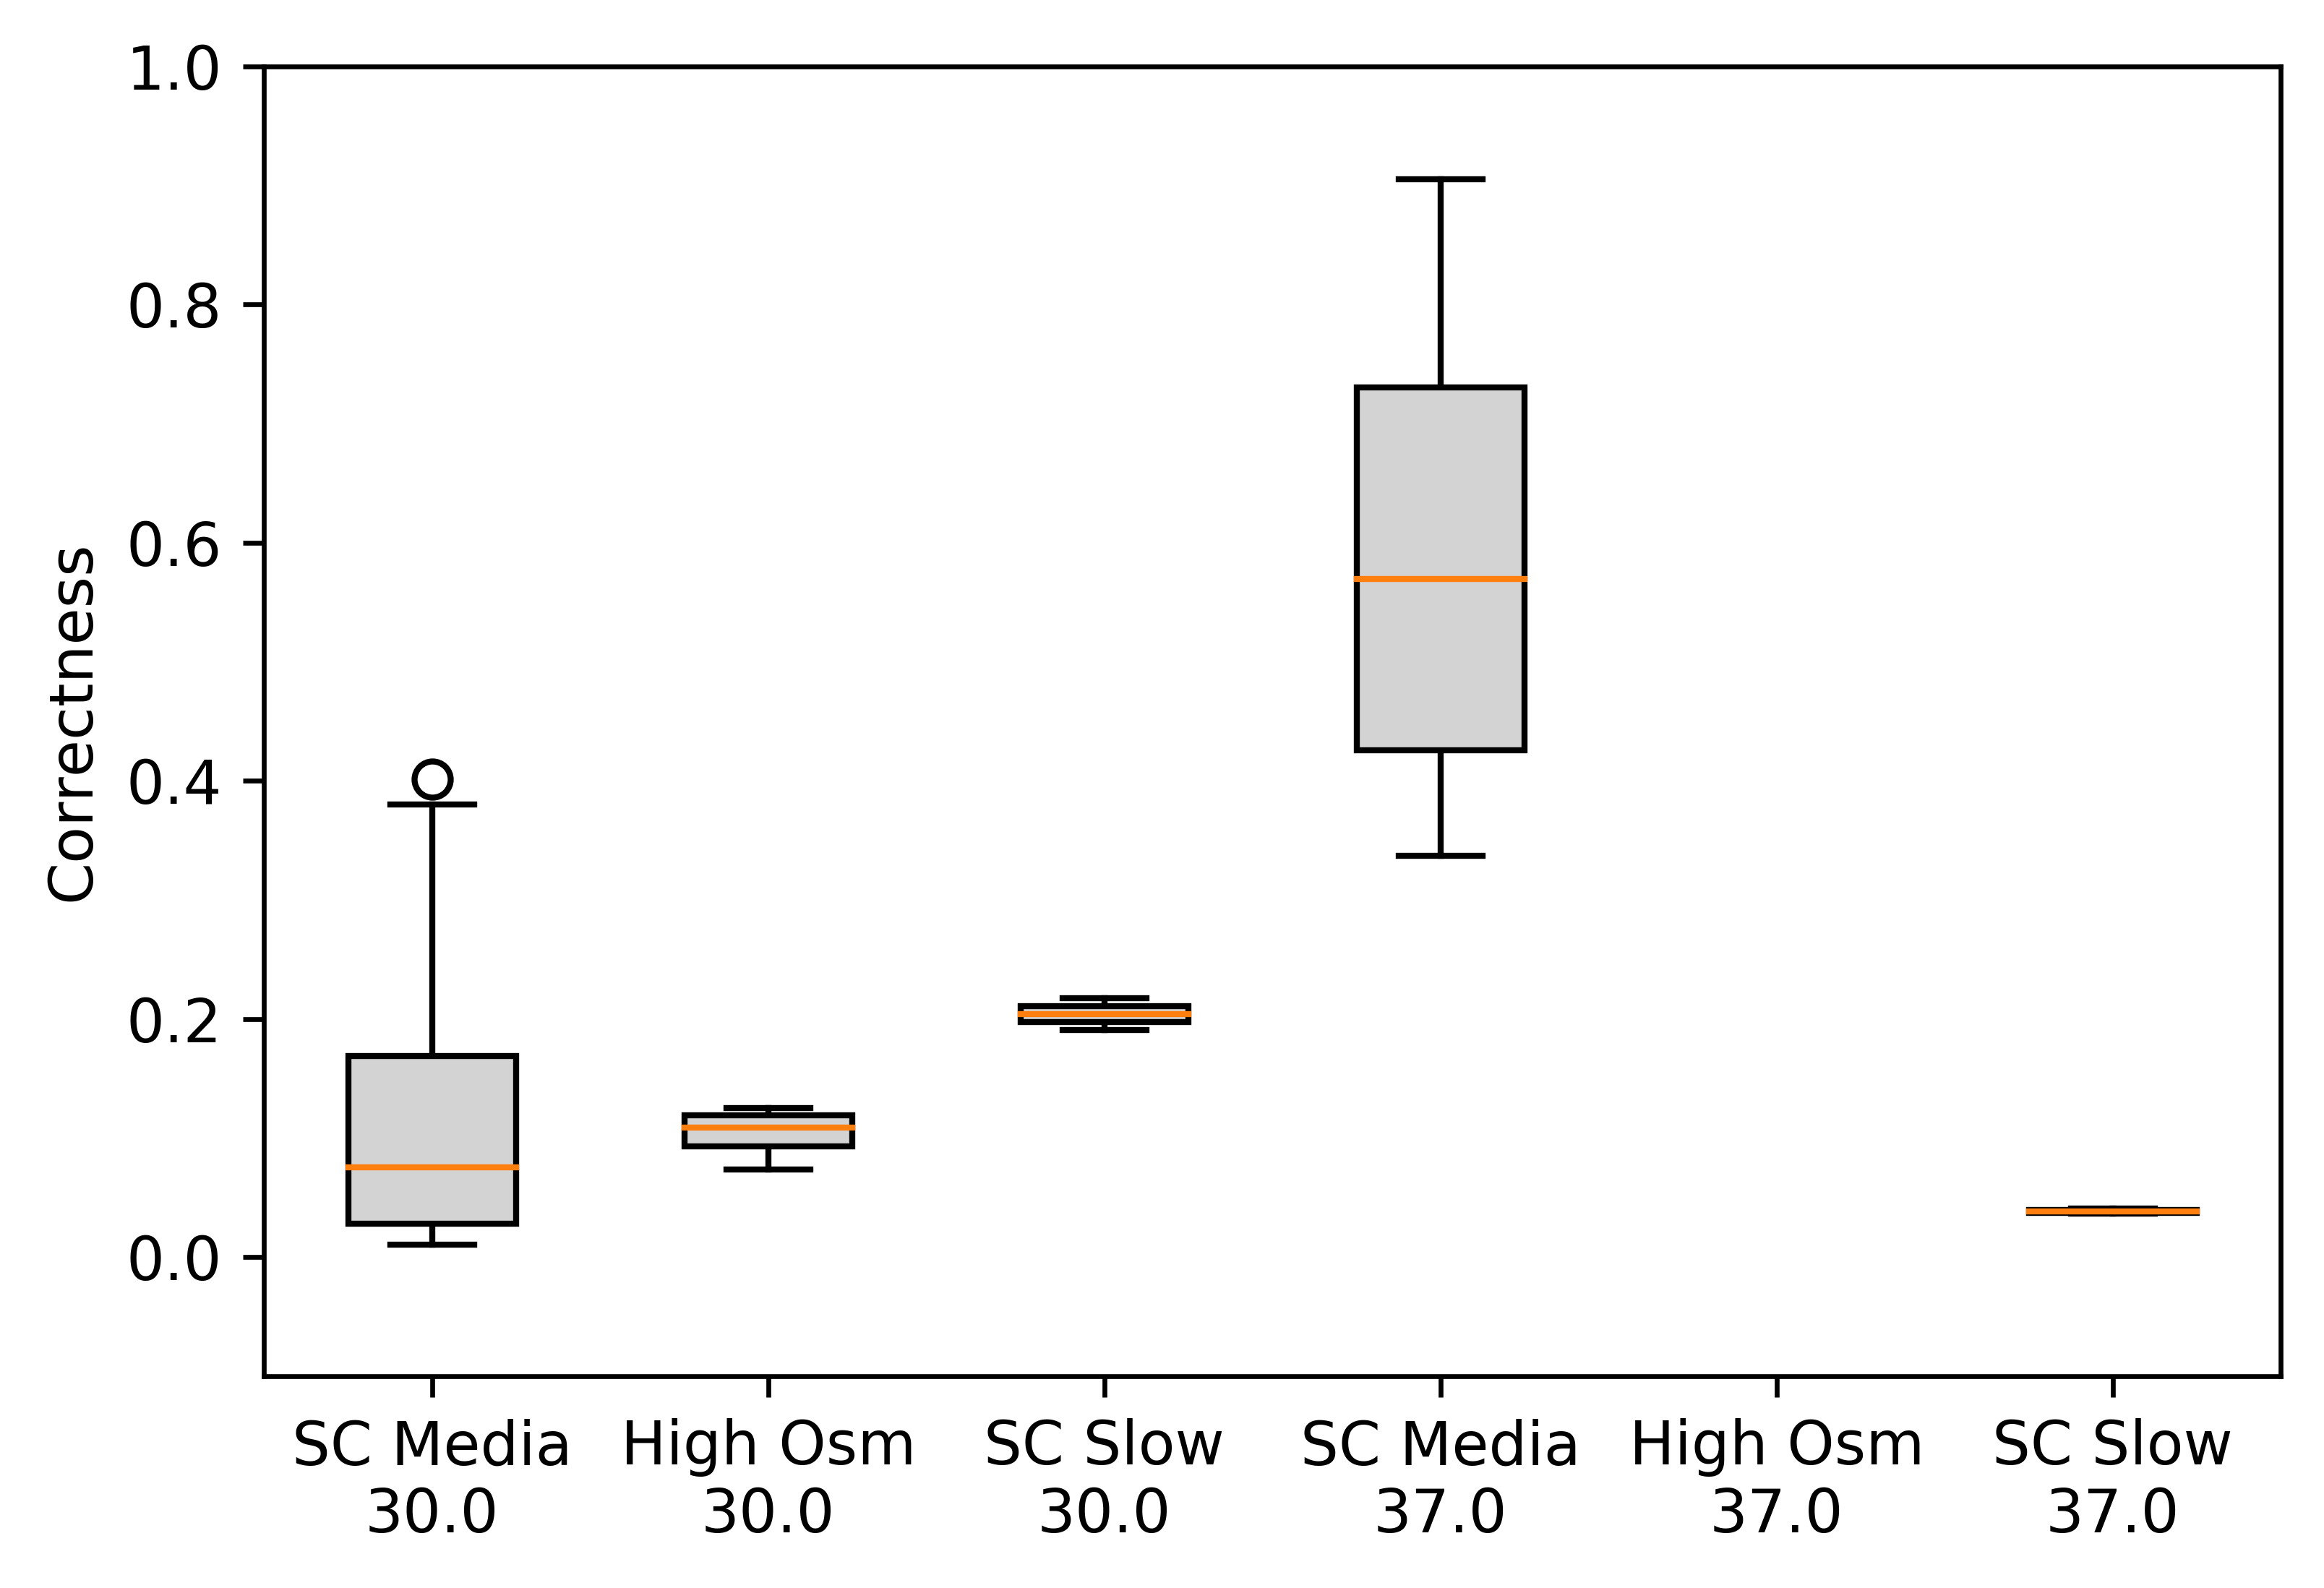

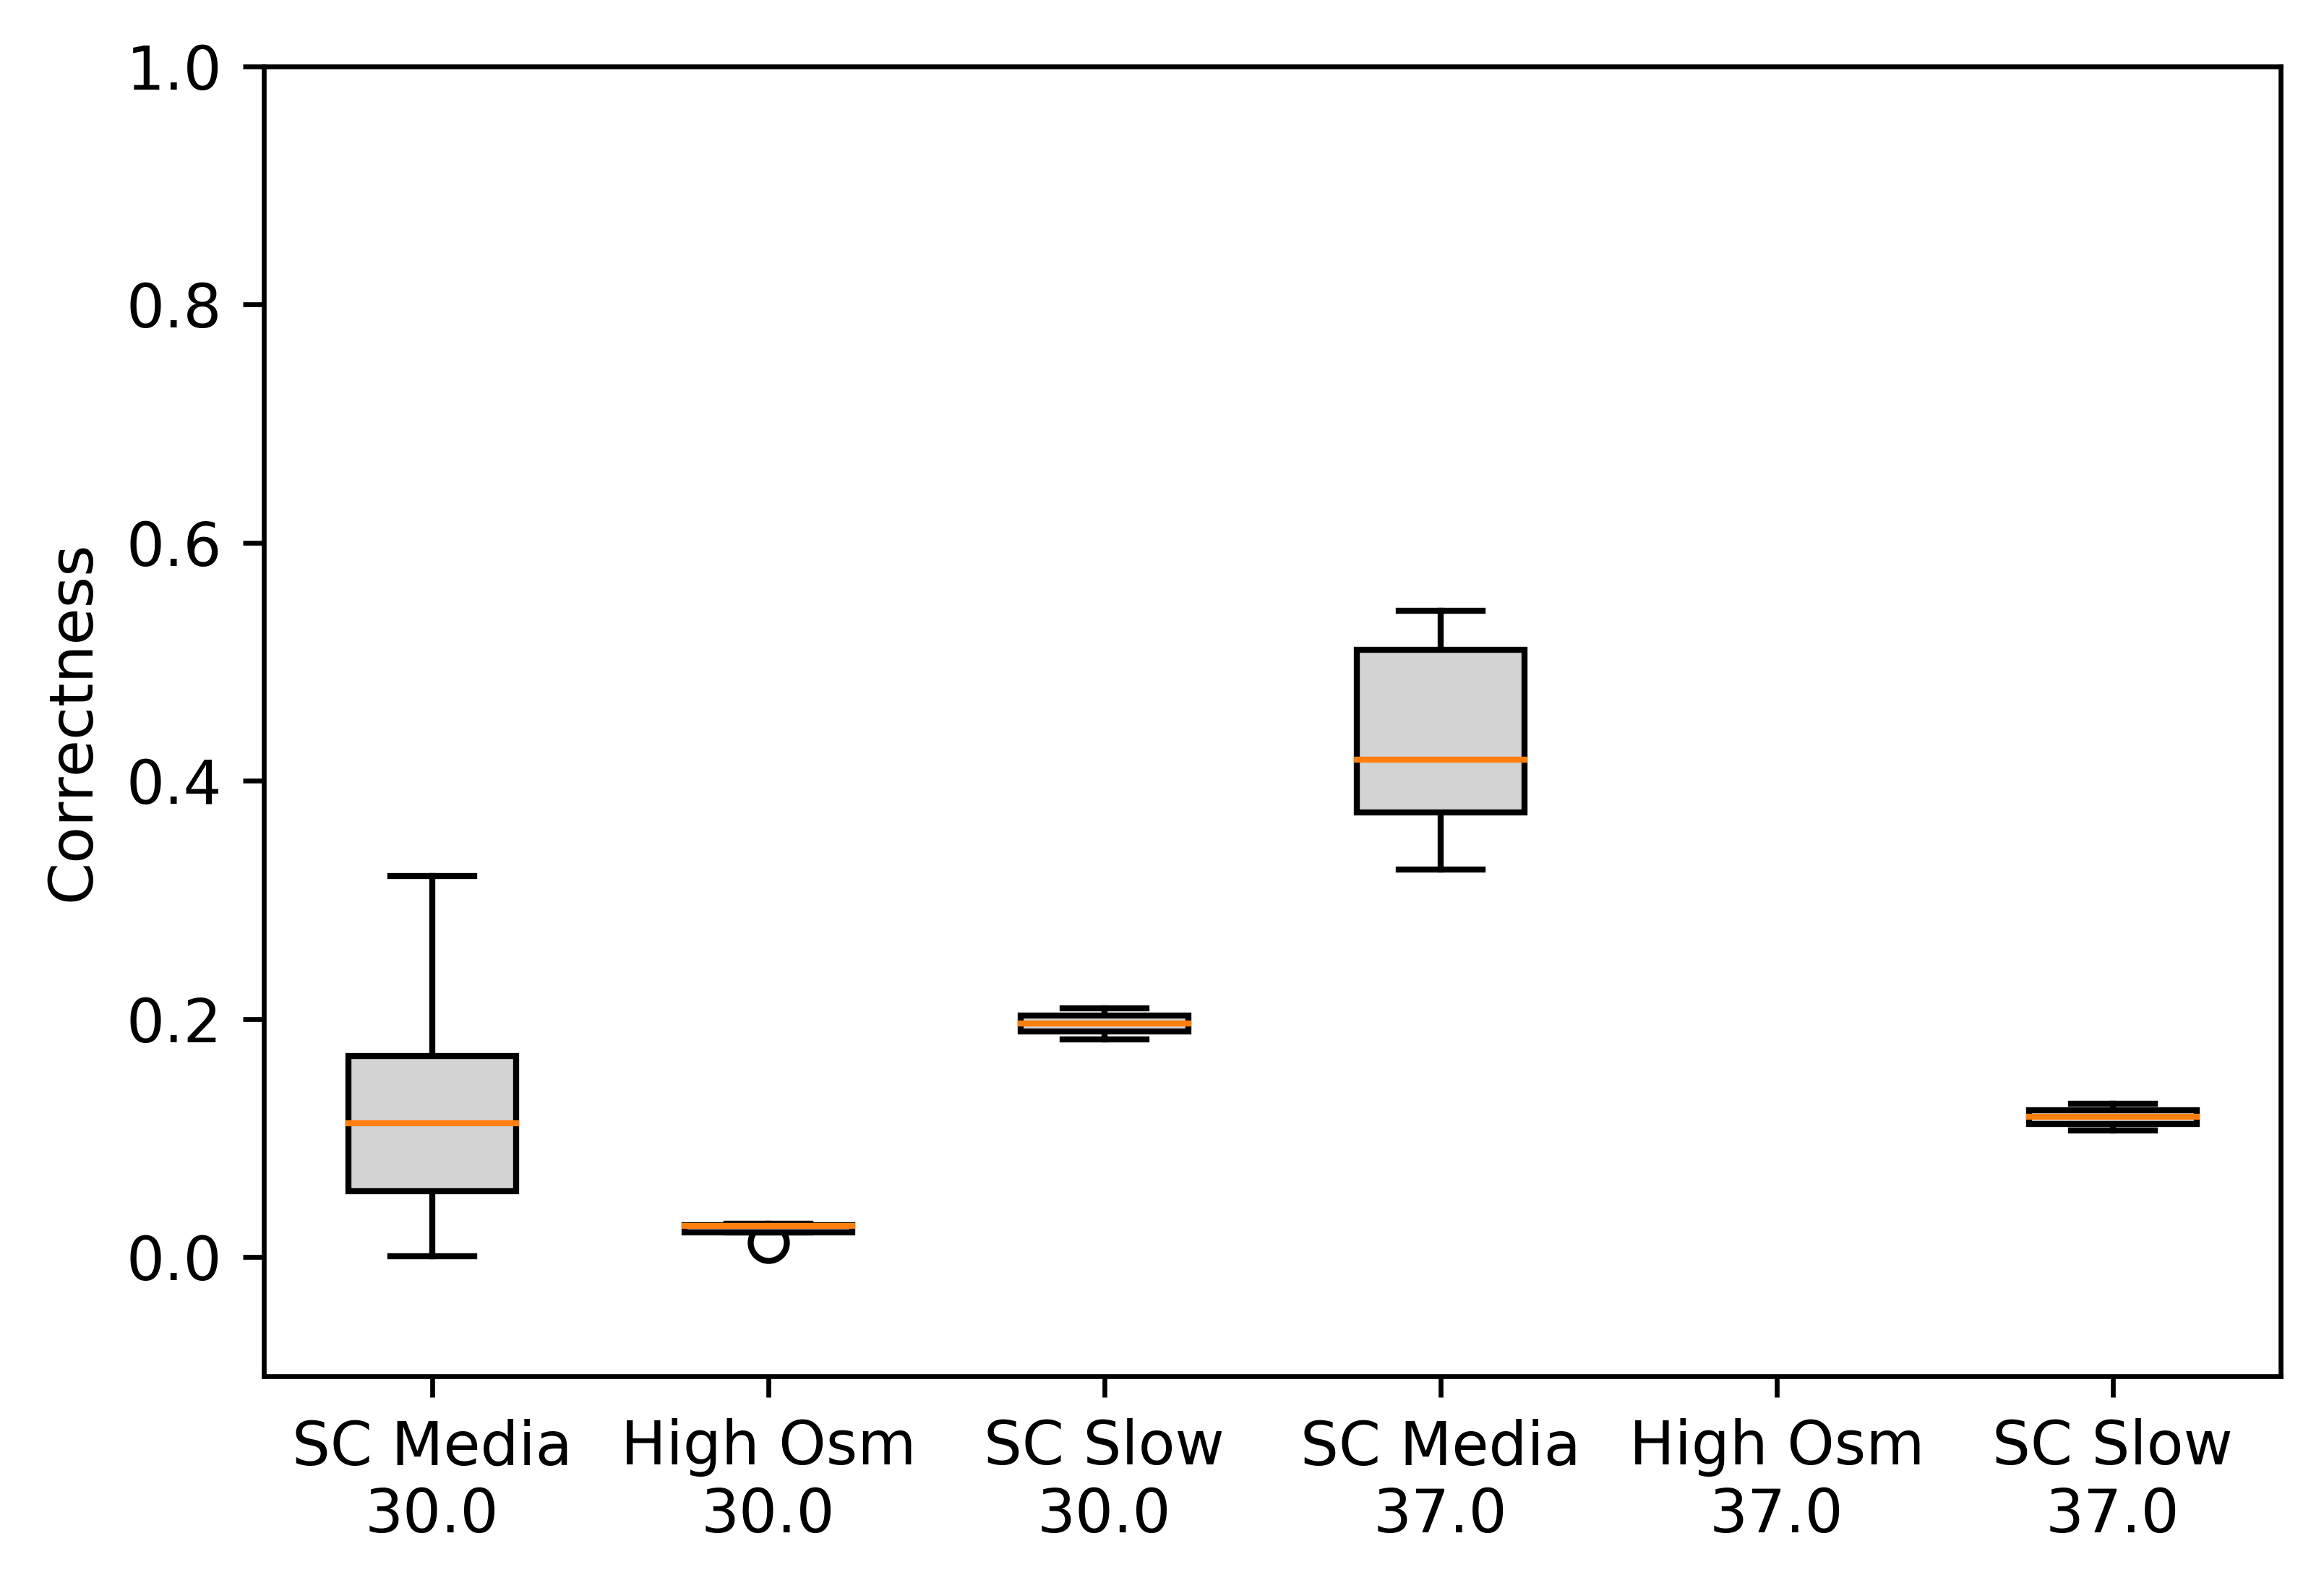

In [29]:
print("NAND")
medians = do_a_gate("NAND",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


OR
[('SC30', (0.01529867874521989, 0.0027477238166458205)), ('OSM30', (0.006731647256989823, 0.003010484173435848)), ('SLOW30', (0.0006512837299461902, 0.0004605271419214192)), ('SC37', (0.00042093659269122624, 0.0001882485670949446)), ('OSM37', (nan, nan)), ('SLOW37', (0.0008258759000832139, 0.000583982449367384))]
[('SC30', (0.03417179022238661, 0.006137434703687341)), ('OSM30', (0.0065988261721086185, 0.0029510847785079192)), ('SLOW30', (0.0009894856904549528, 0.0006996720416077502)), ('SC37', (0.006128646941949148, 0.0027408142344589)), ('OSM37', (nan, nan)), ('SLOW37', (0.0026782107316168785, 0.0018937809697728793))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

Percent of threshold median at least 0.0 below classifier median: 0.2.
Percent of threshold median above classifier median: 0.8.


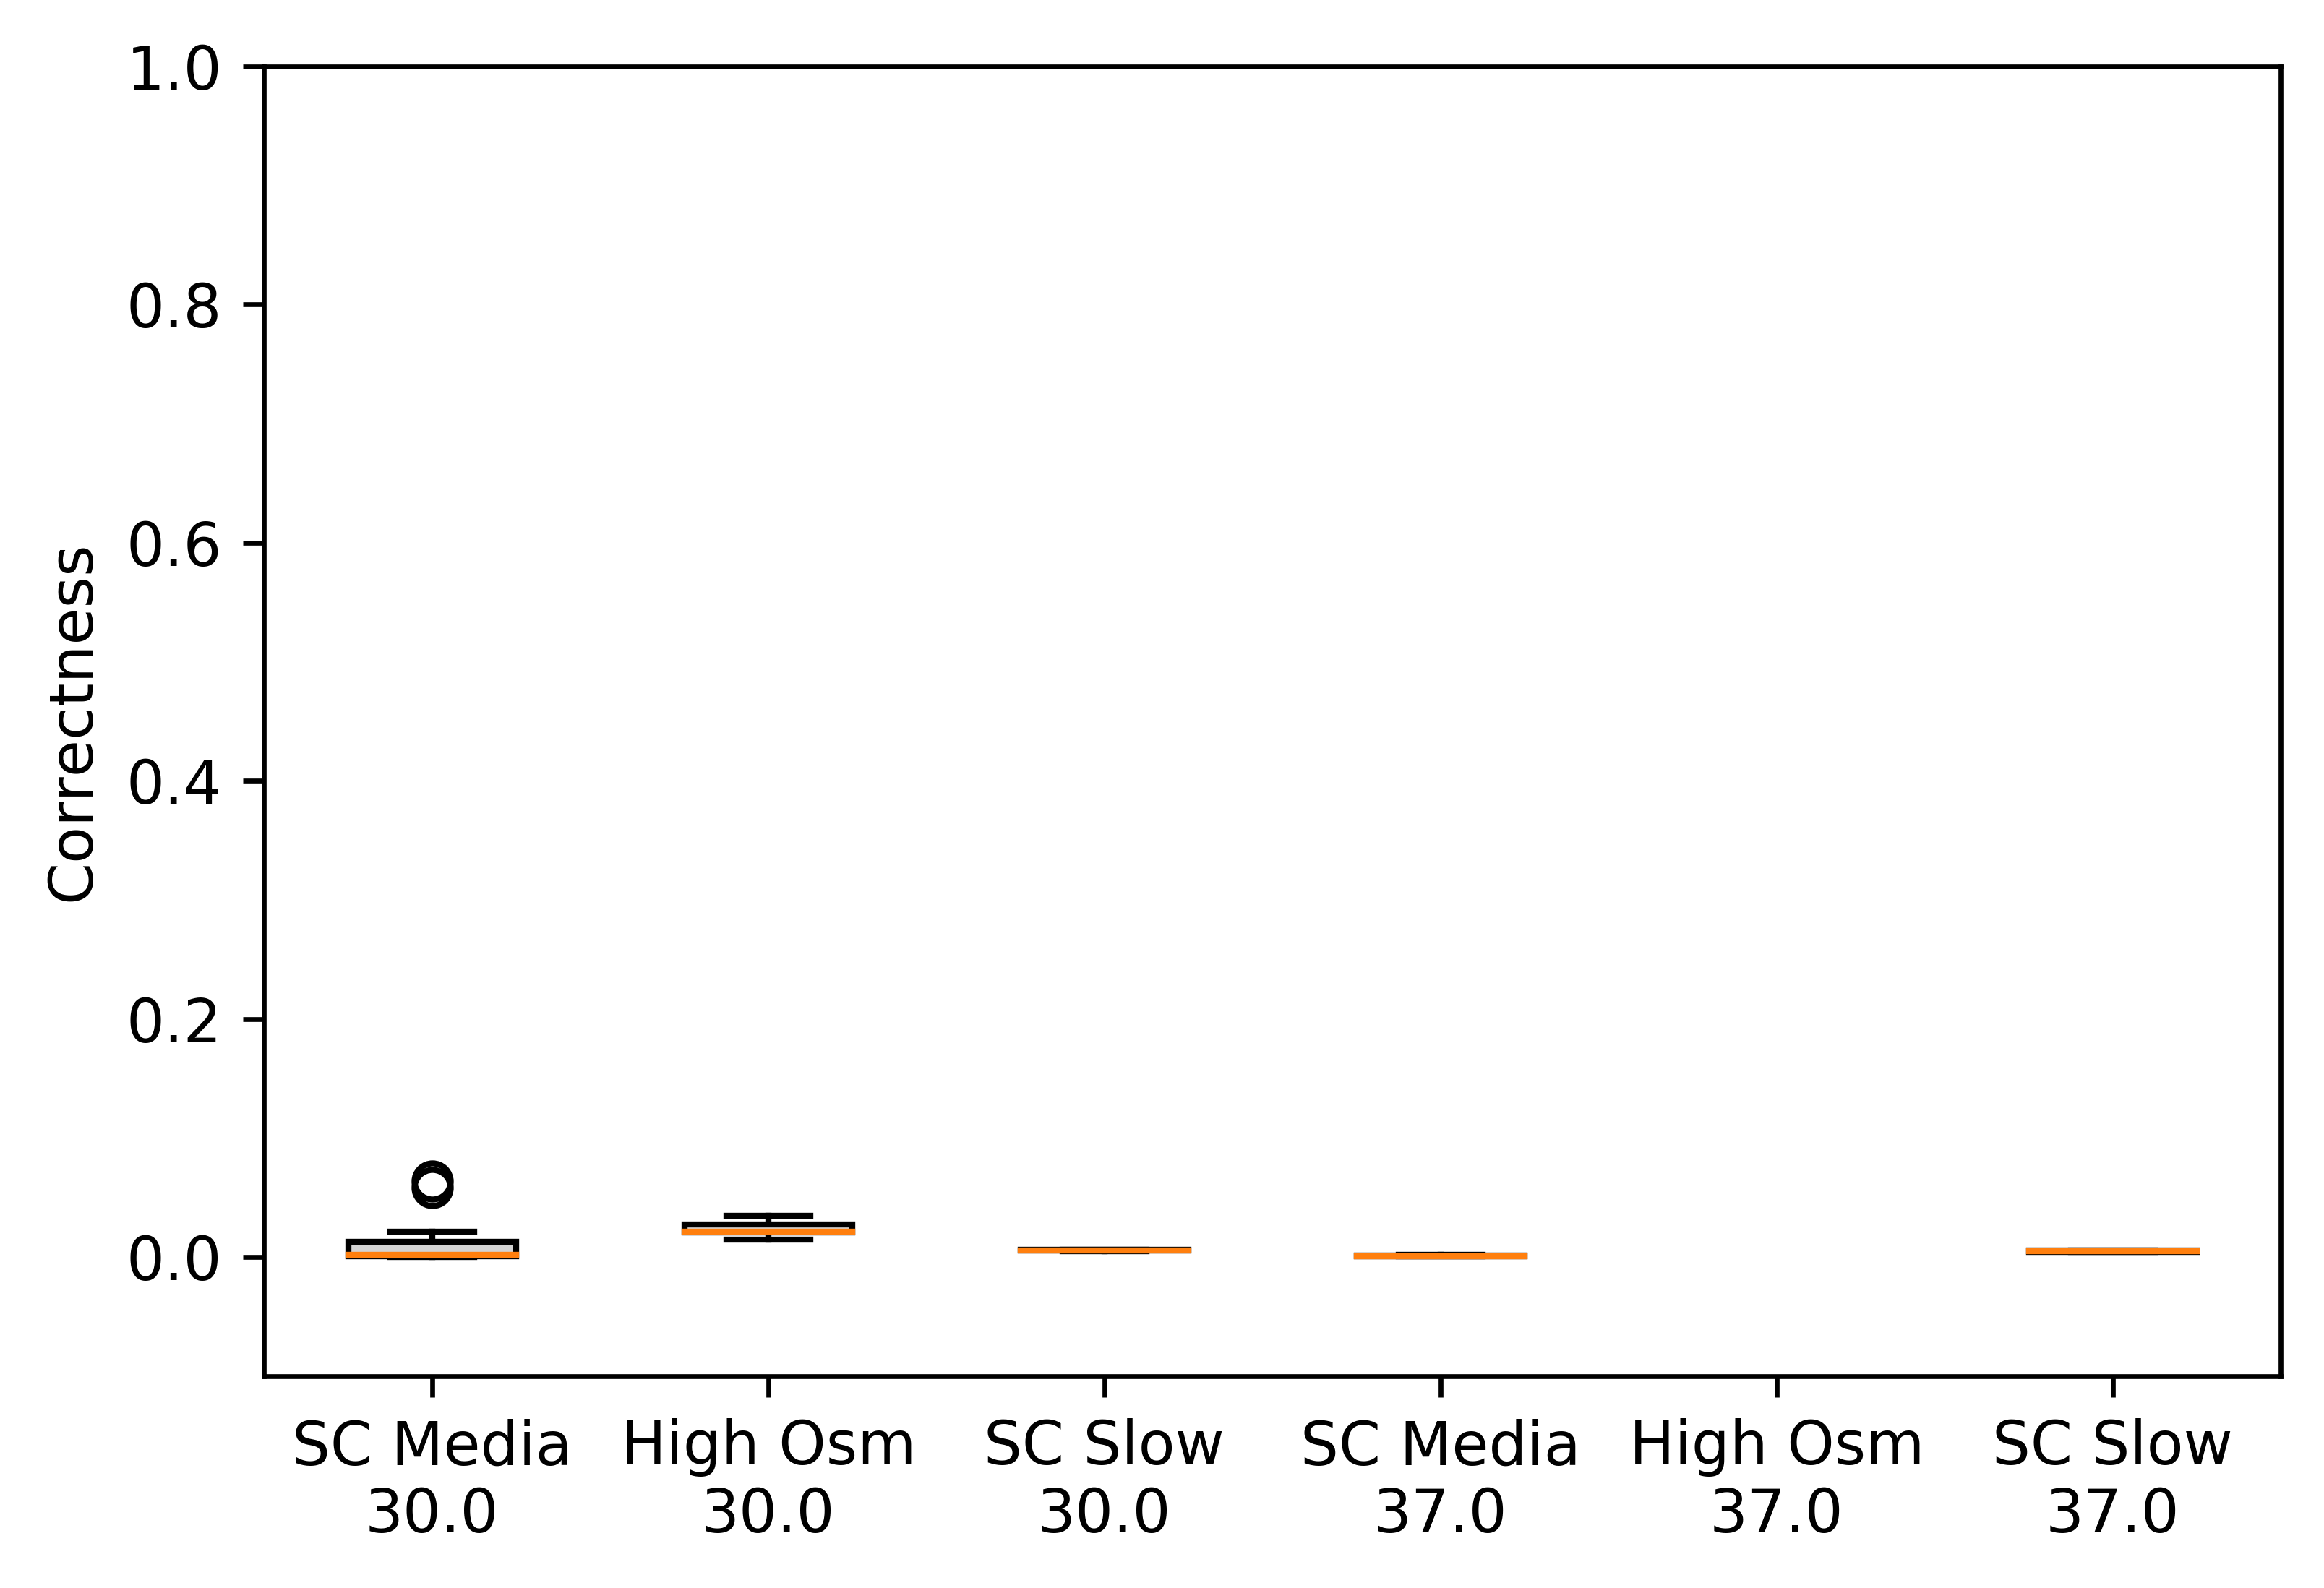

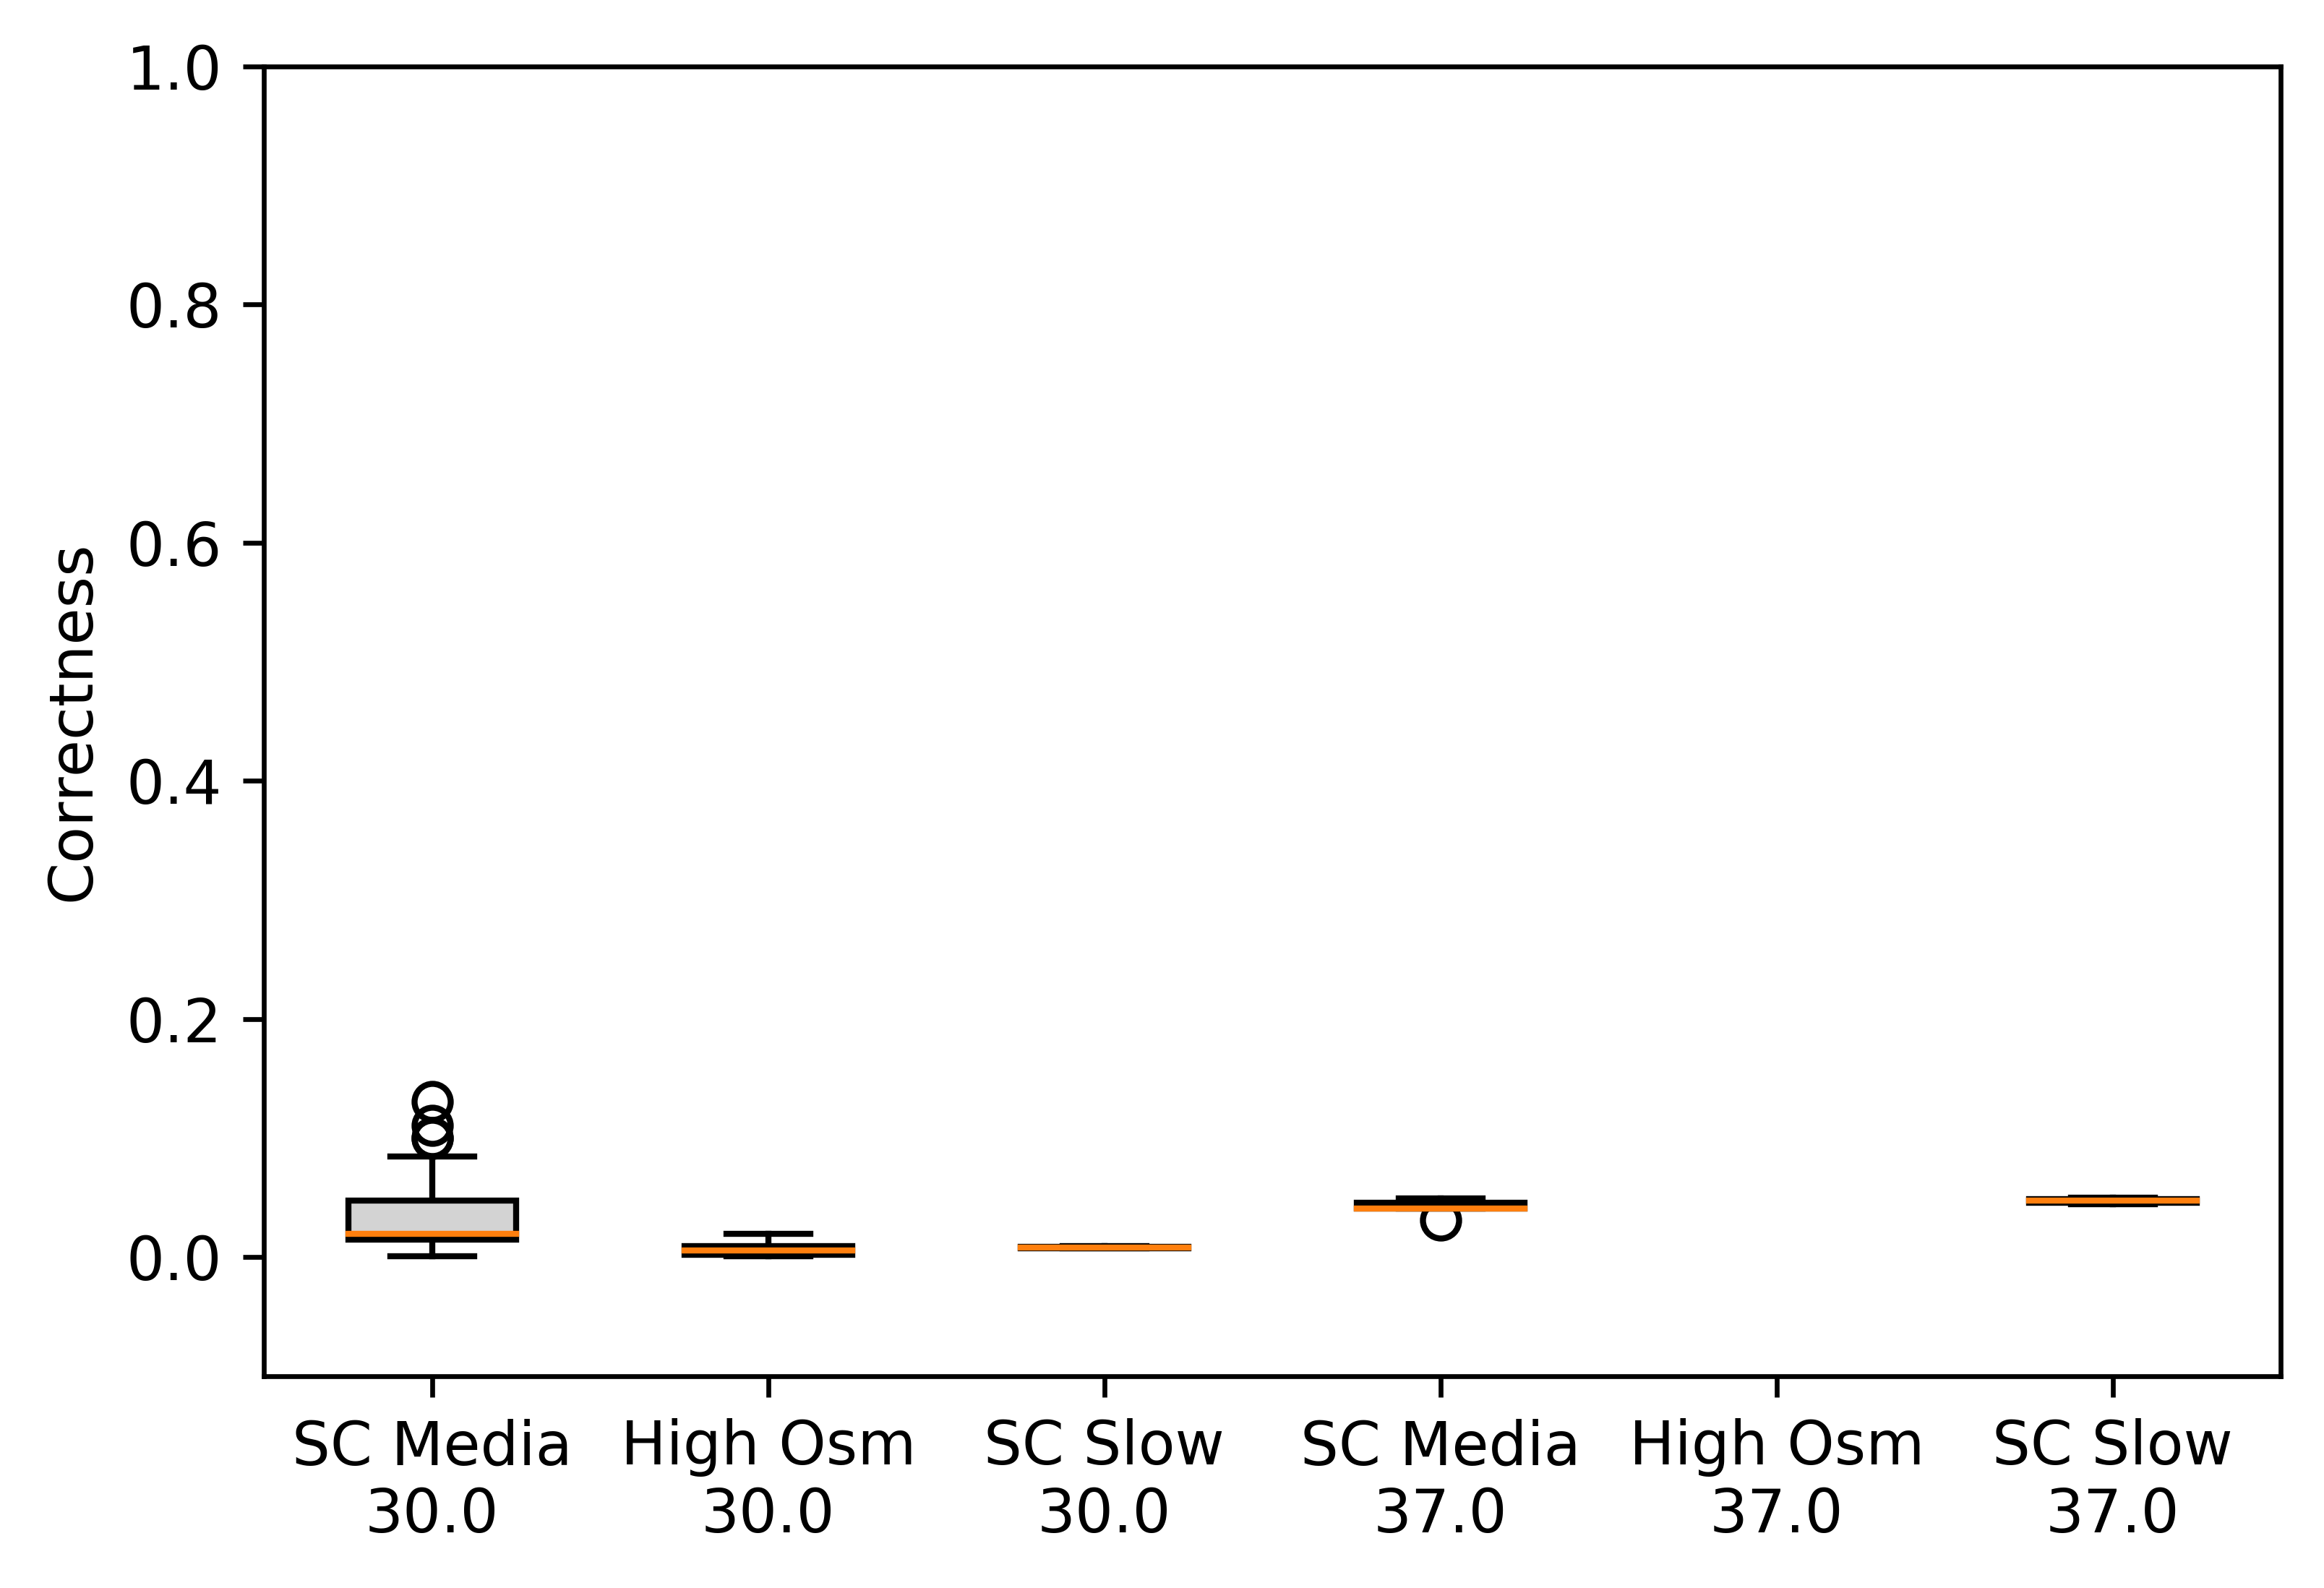

In [30]:
print("OR")
medians = do_a_gate("OR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


NOR
[('SC30', (0.19154720619786655, 0.03440289382155275)), ('OSM30', (0.04606506203013093, 0.020600922017423445)), ('SLOW30', (0.04354886458581575, 0.030793697461605003)), ('SC37', (0.05885456586962649, 0.02632056201414477)), ('OSM37', (nan, nan)), ('SLOW37', (0.06687848166380106, 0.0472902278999339))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

[('SC30', (0.17070672583771718, 0.030659833052085056)), ('OSM30', (0.05572978260787086, 0.02492311645649695)), ('SLOW30', (0.039812609651545955, 0.028151766261341134)), ('SC37', (0.04006621123139354, 0.0179181543828523)), ('OSM37', (nan, nan)), ('SLOW37', (0.002559270108567109, 0.0018096772486558344))]
Percent of threshold median at least 0.0 below classifier median: 1.0.
Percent of threshold median above classifier median: 0.0.


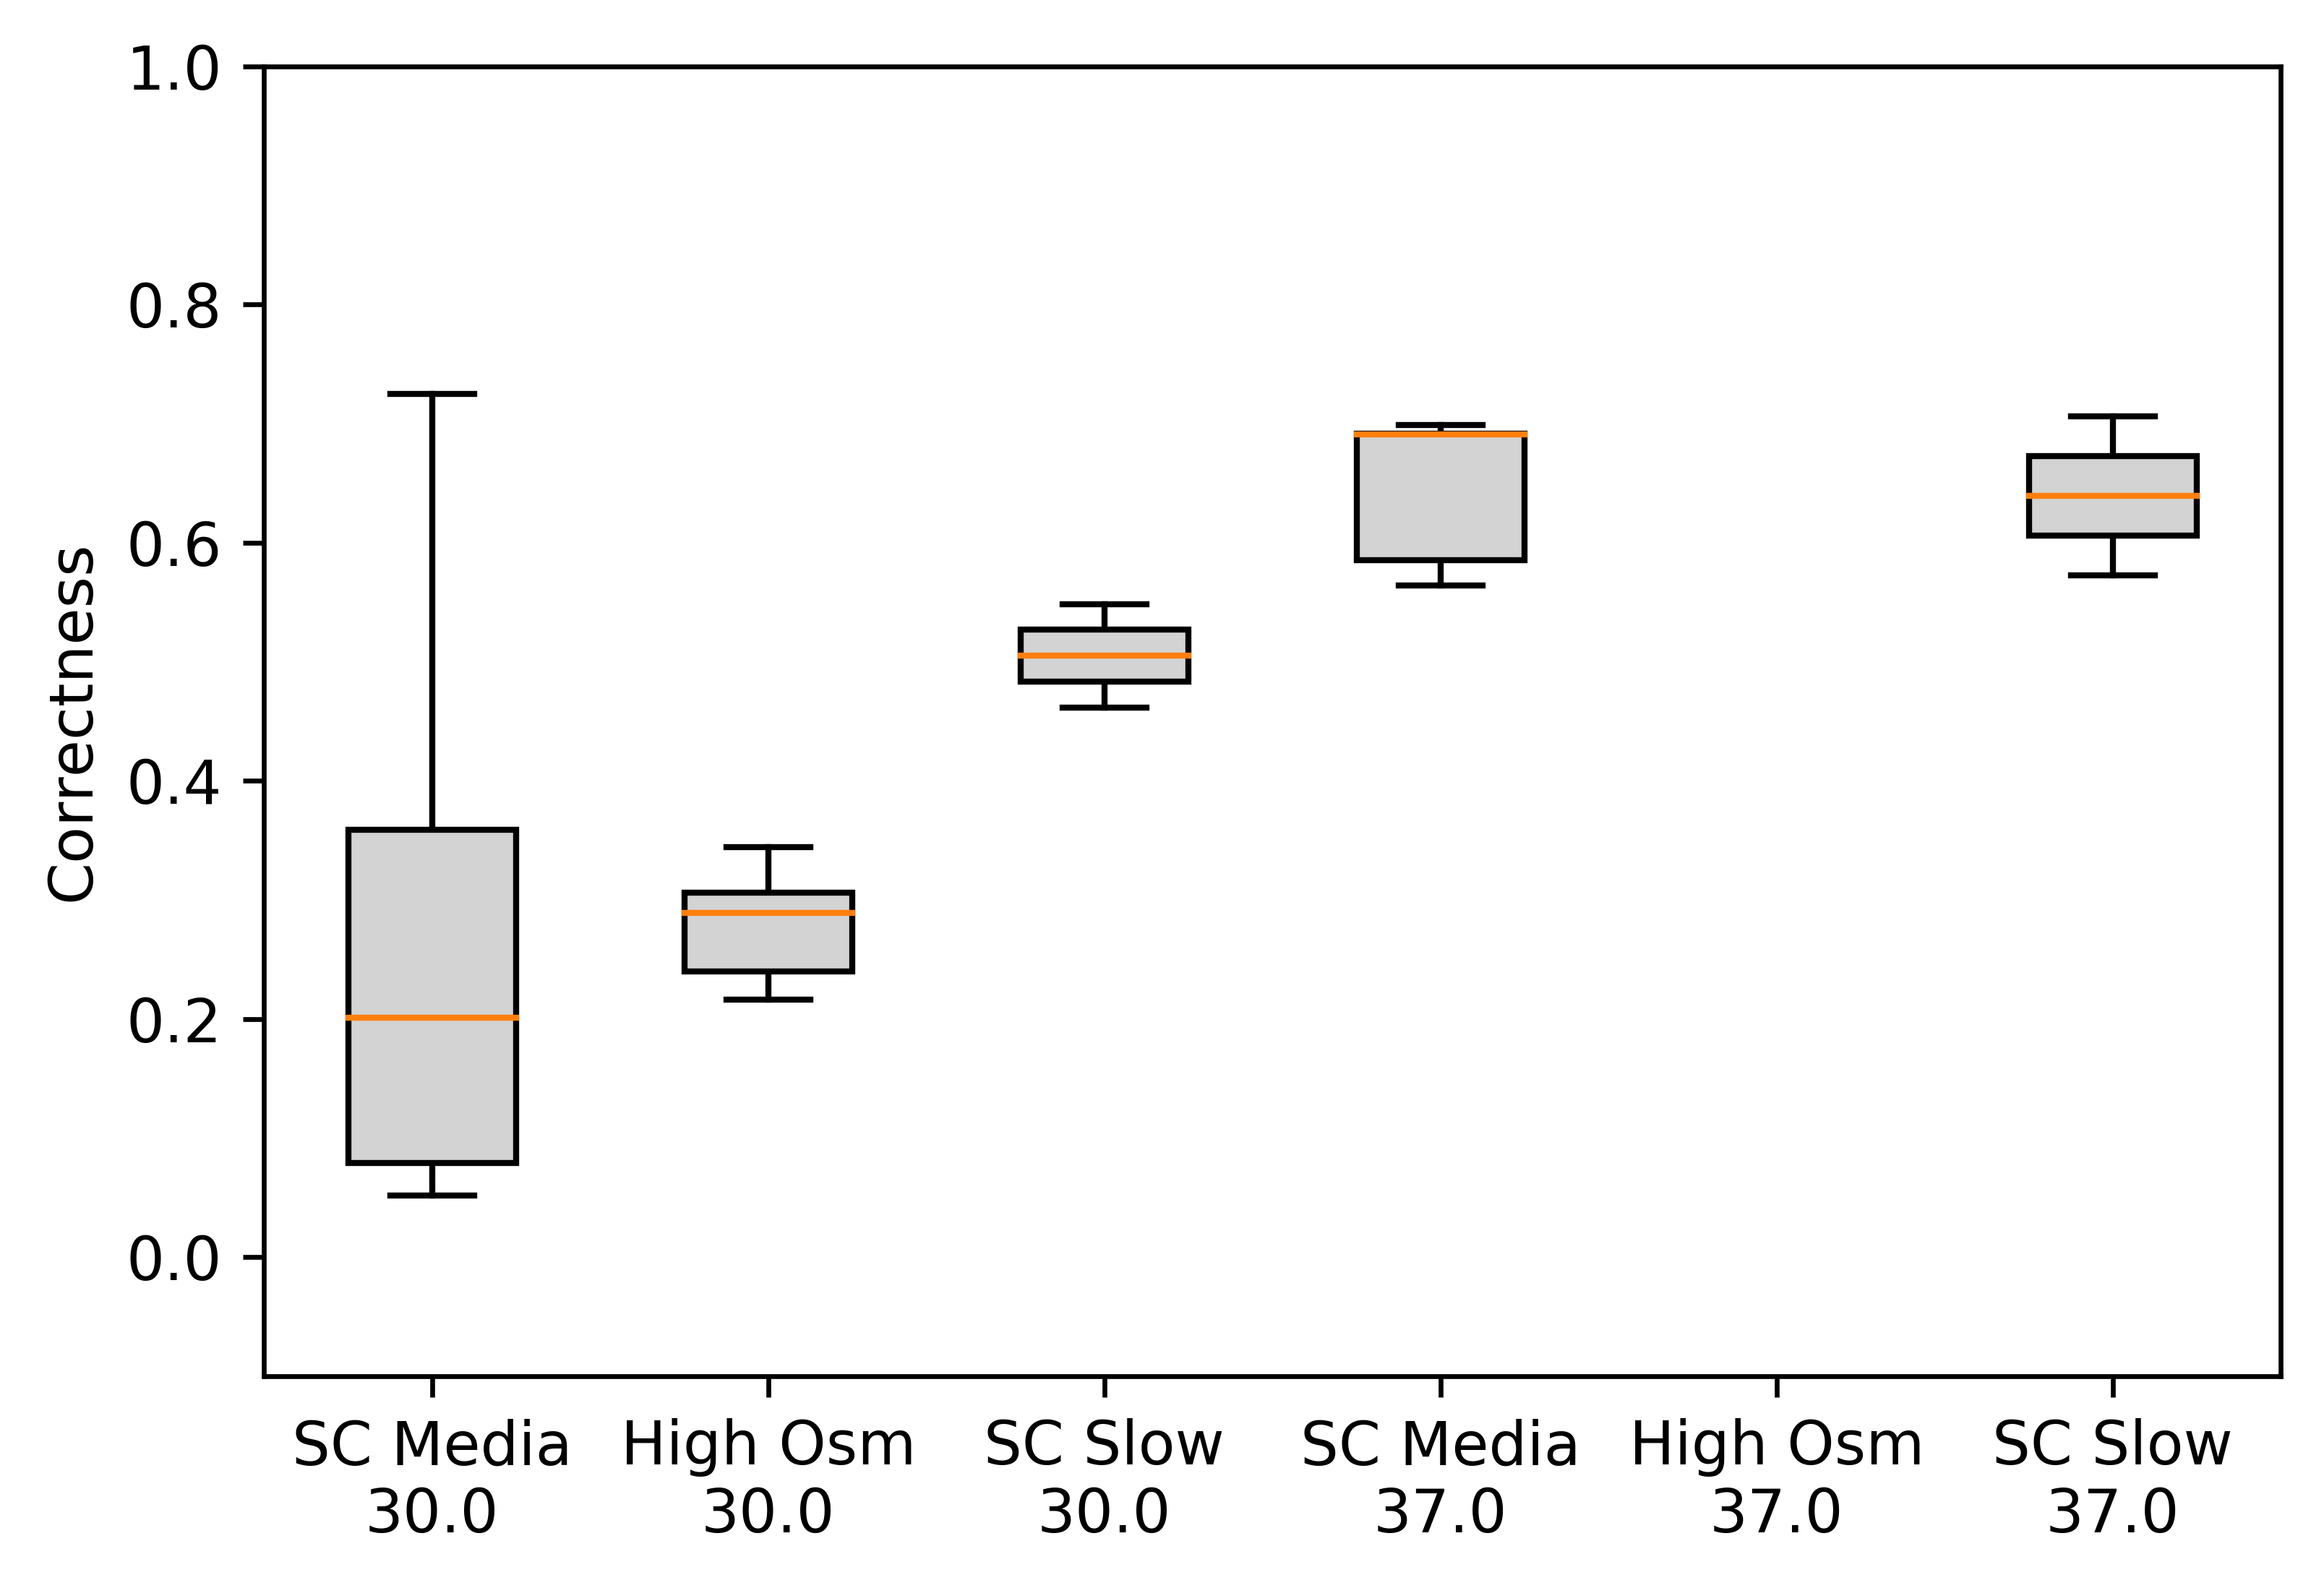

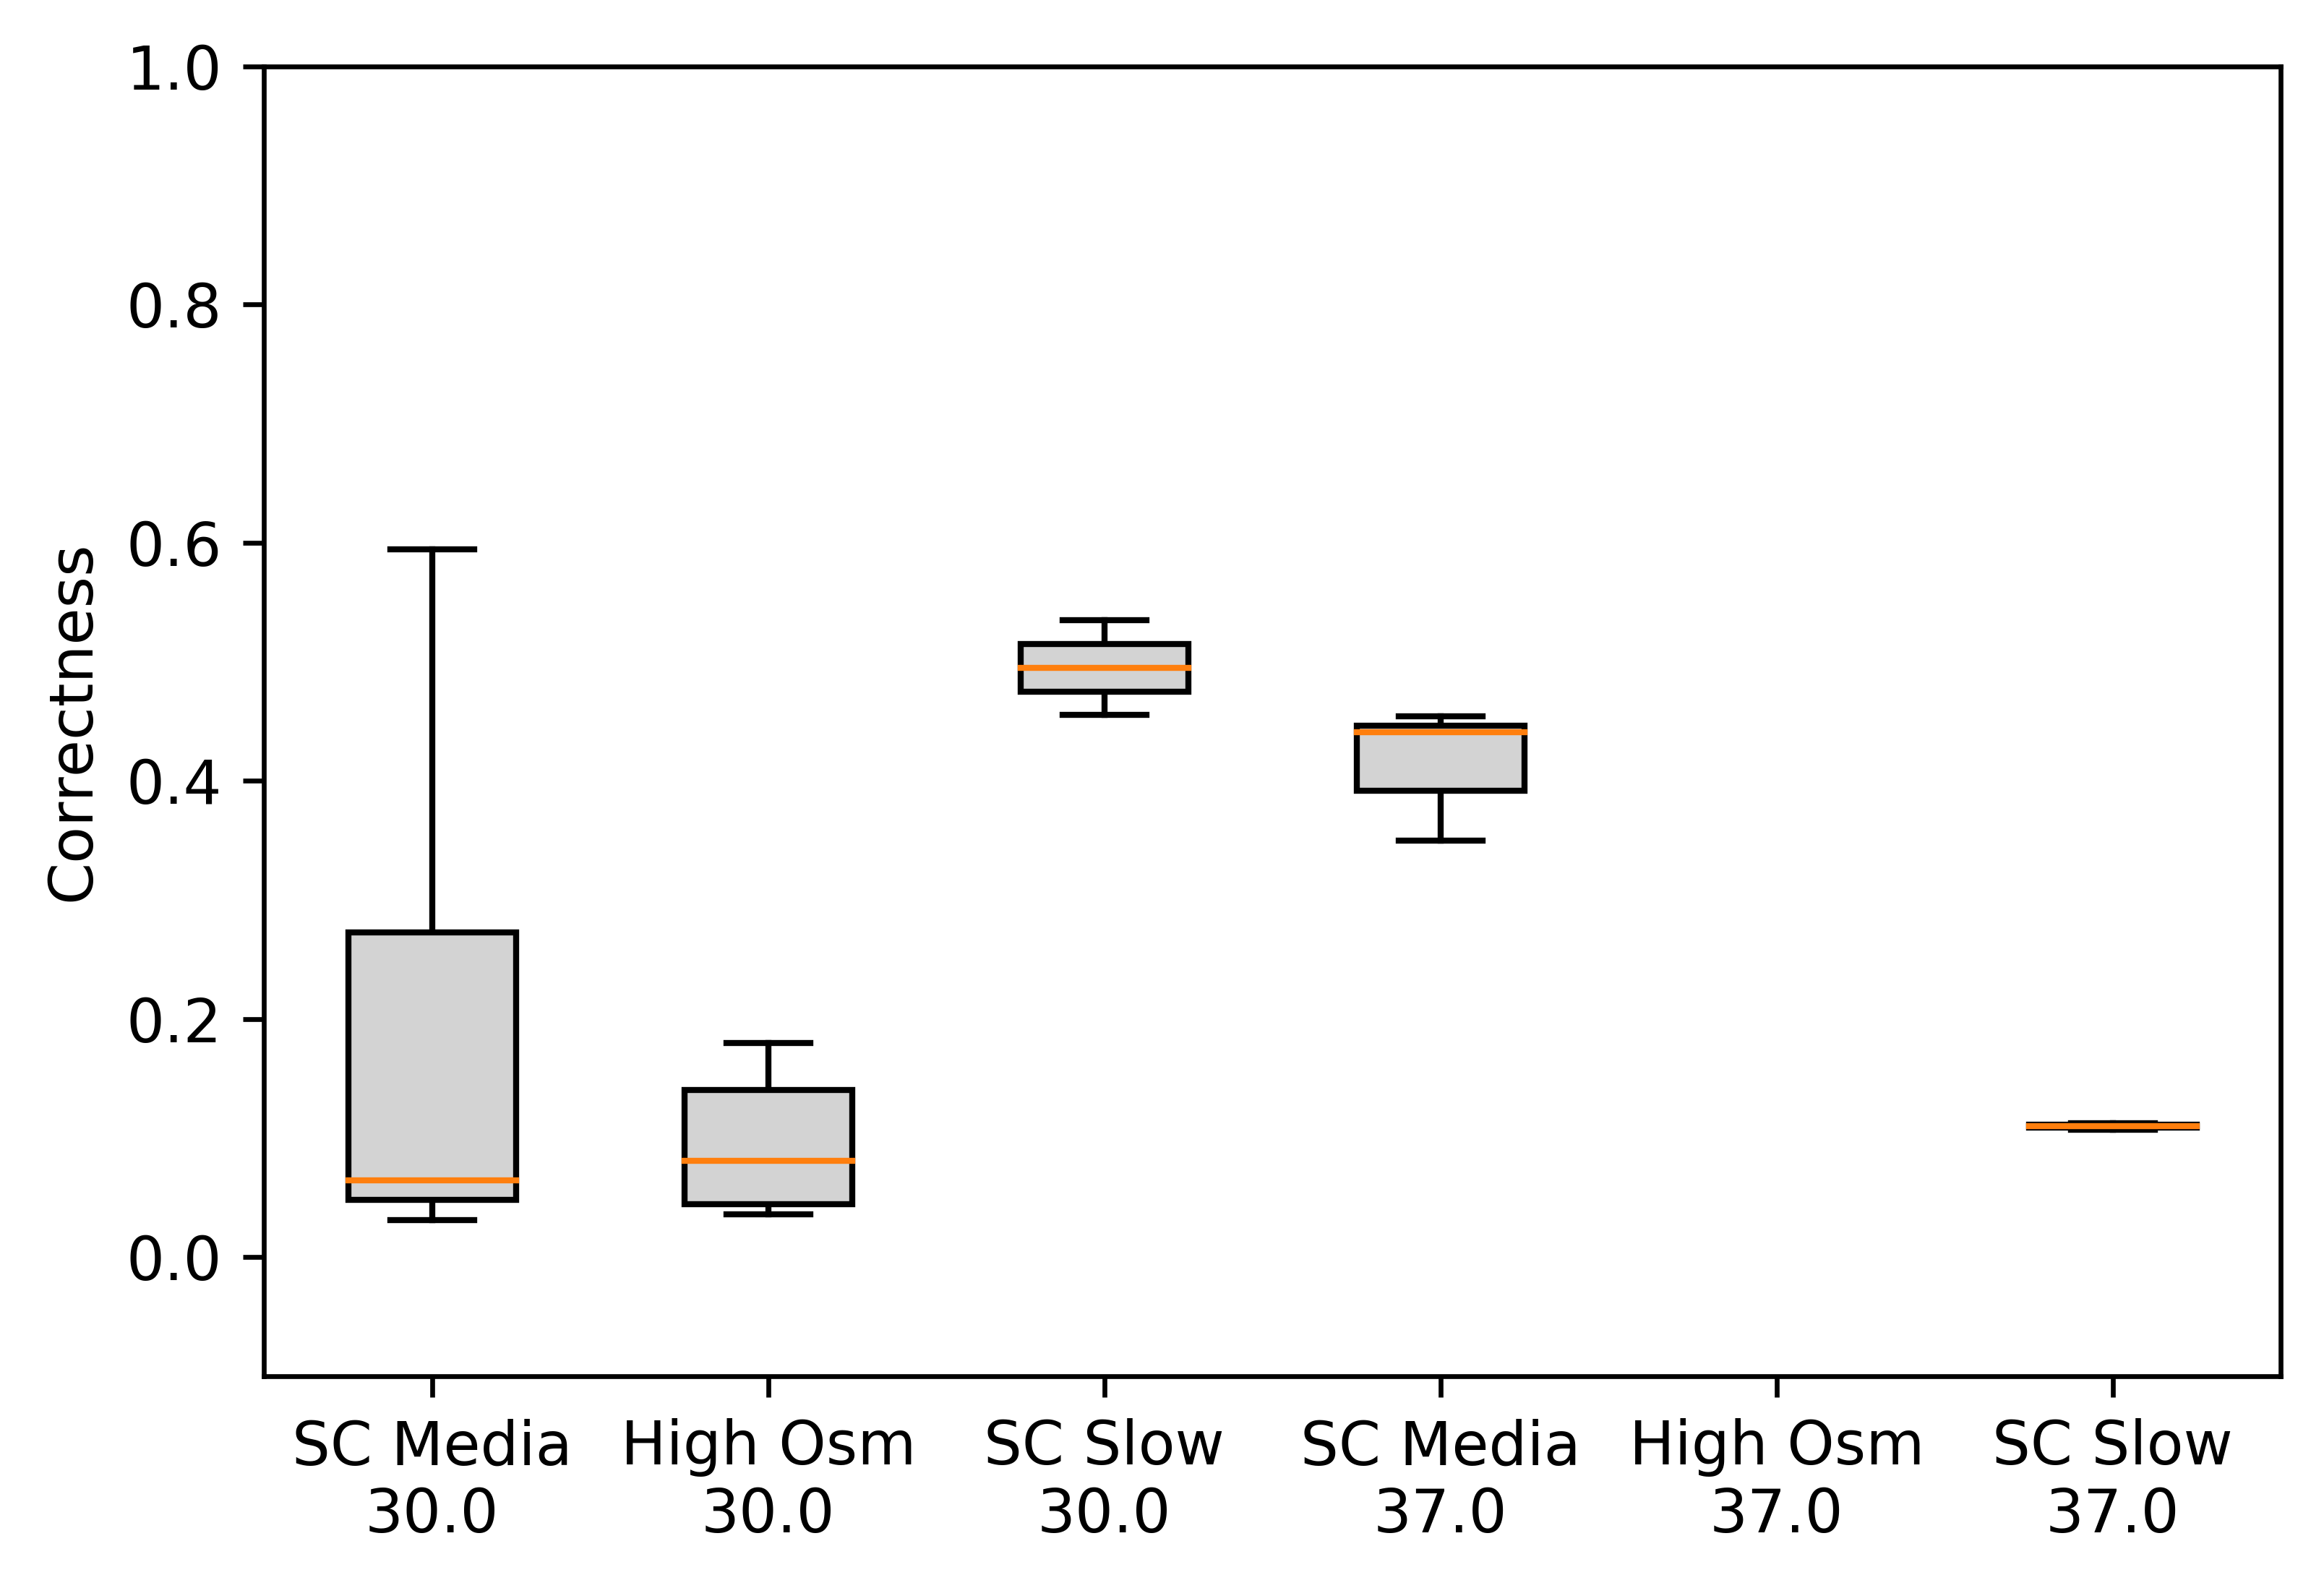

In [31]:
print("NOR")
medians = do_a_gate("NOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


XOR
[('SC30', (0.09110458428981562, 0.016362866377396108)), ('OSM30', (0.02887926154945888, 0.012915198392917191)), ('SLOW30', (0.025259997941870685, 0.017861515837454996)), ('SC37', (0.12208182641009821, 0.05459665253406174)), ('OSM37', (nan, nan)), ('SLOW37', (0.06340310793935028, 0.04483276757221721))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

[('SC30', (0.06412434524347967, 0.011517072394724354)), ('OSM30', (0.017874225602257893, 0.007993596698363152)), ('SLOW30', (0.013951852902935727, 0.00986544979778307)), ('SC37', (0.04676418220890386, 0.02091357806625906)), ('OSM37', (nan, nan)), ('SLOW37', (0.005657156949687374, 0.004000214041360546))]
Percent of threshold median at least 0.0 below classifier median: 0.8.
Percent of threshold median above classifier median: 0.2.


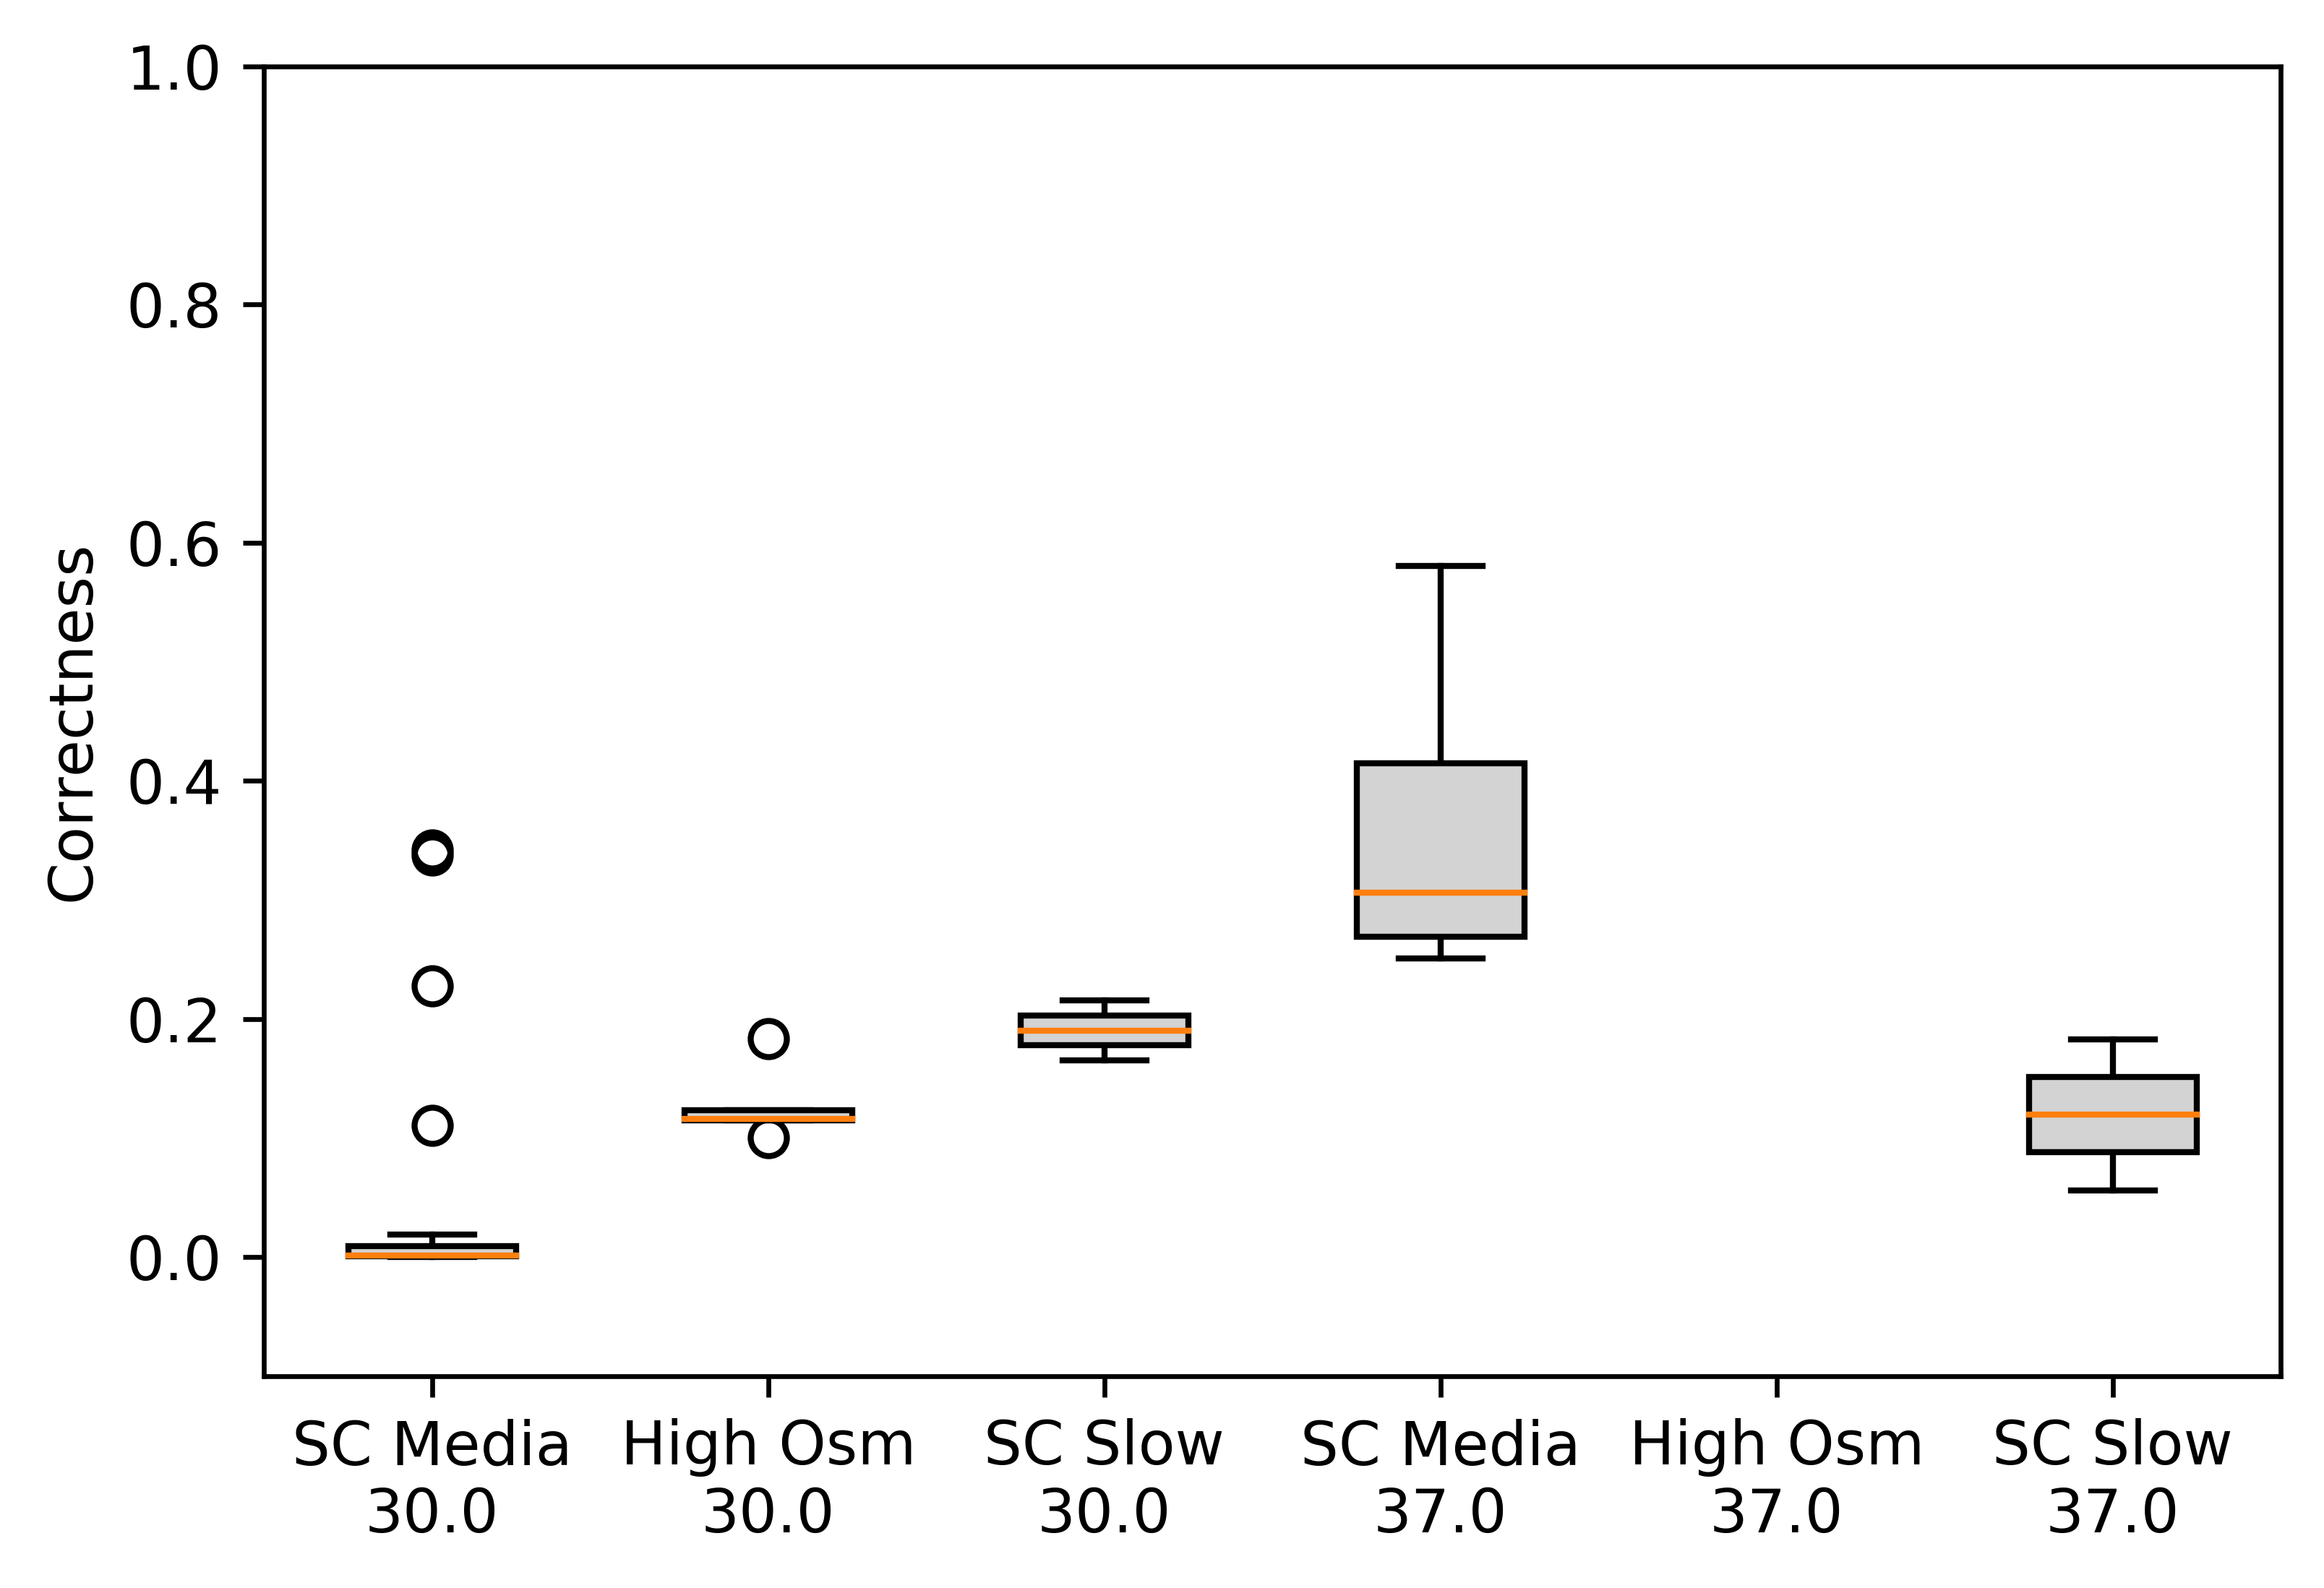

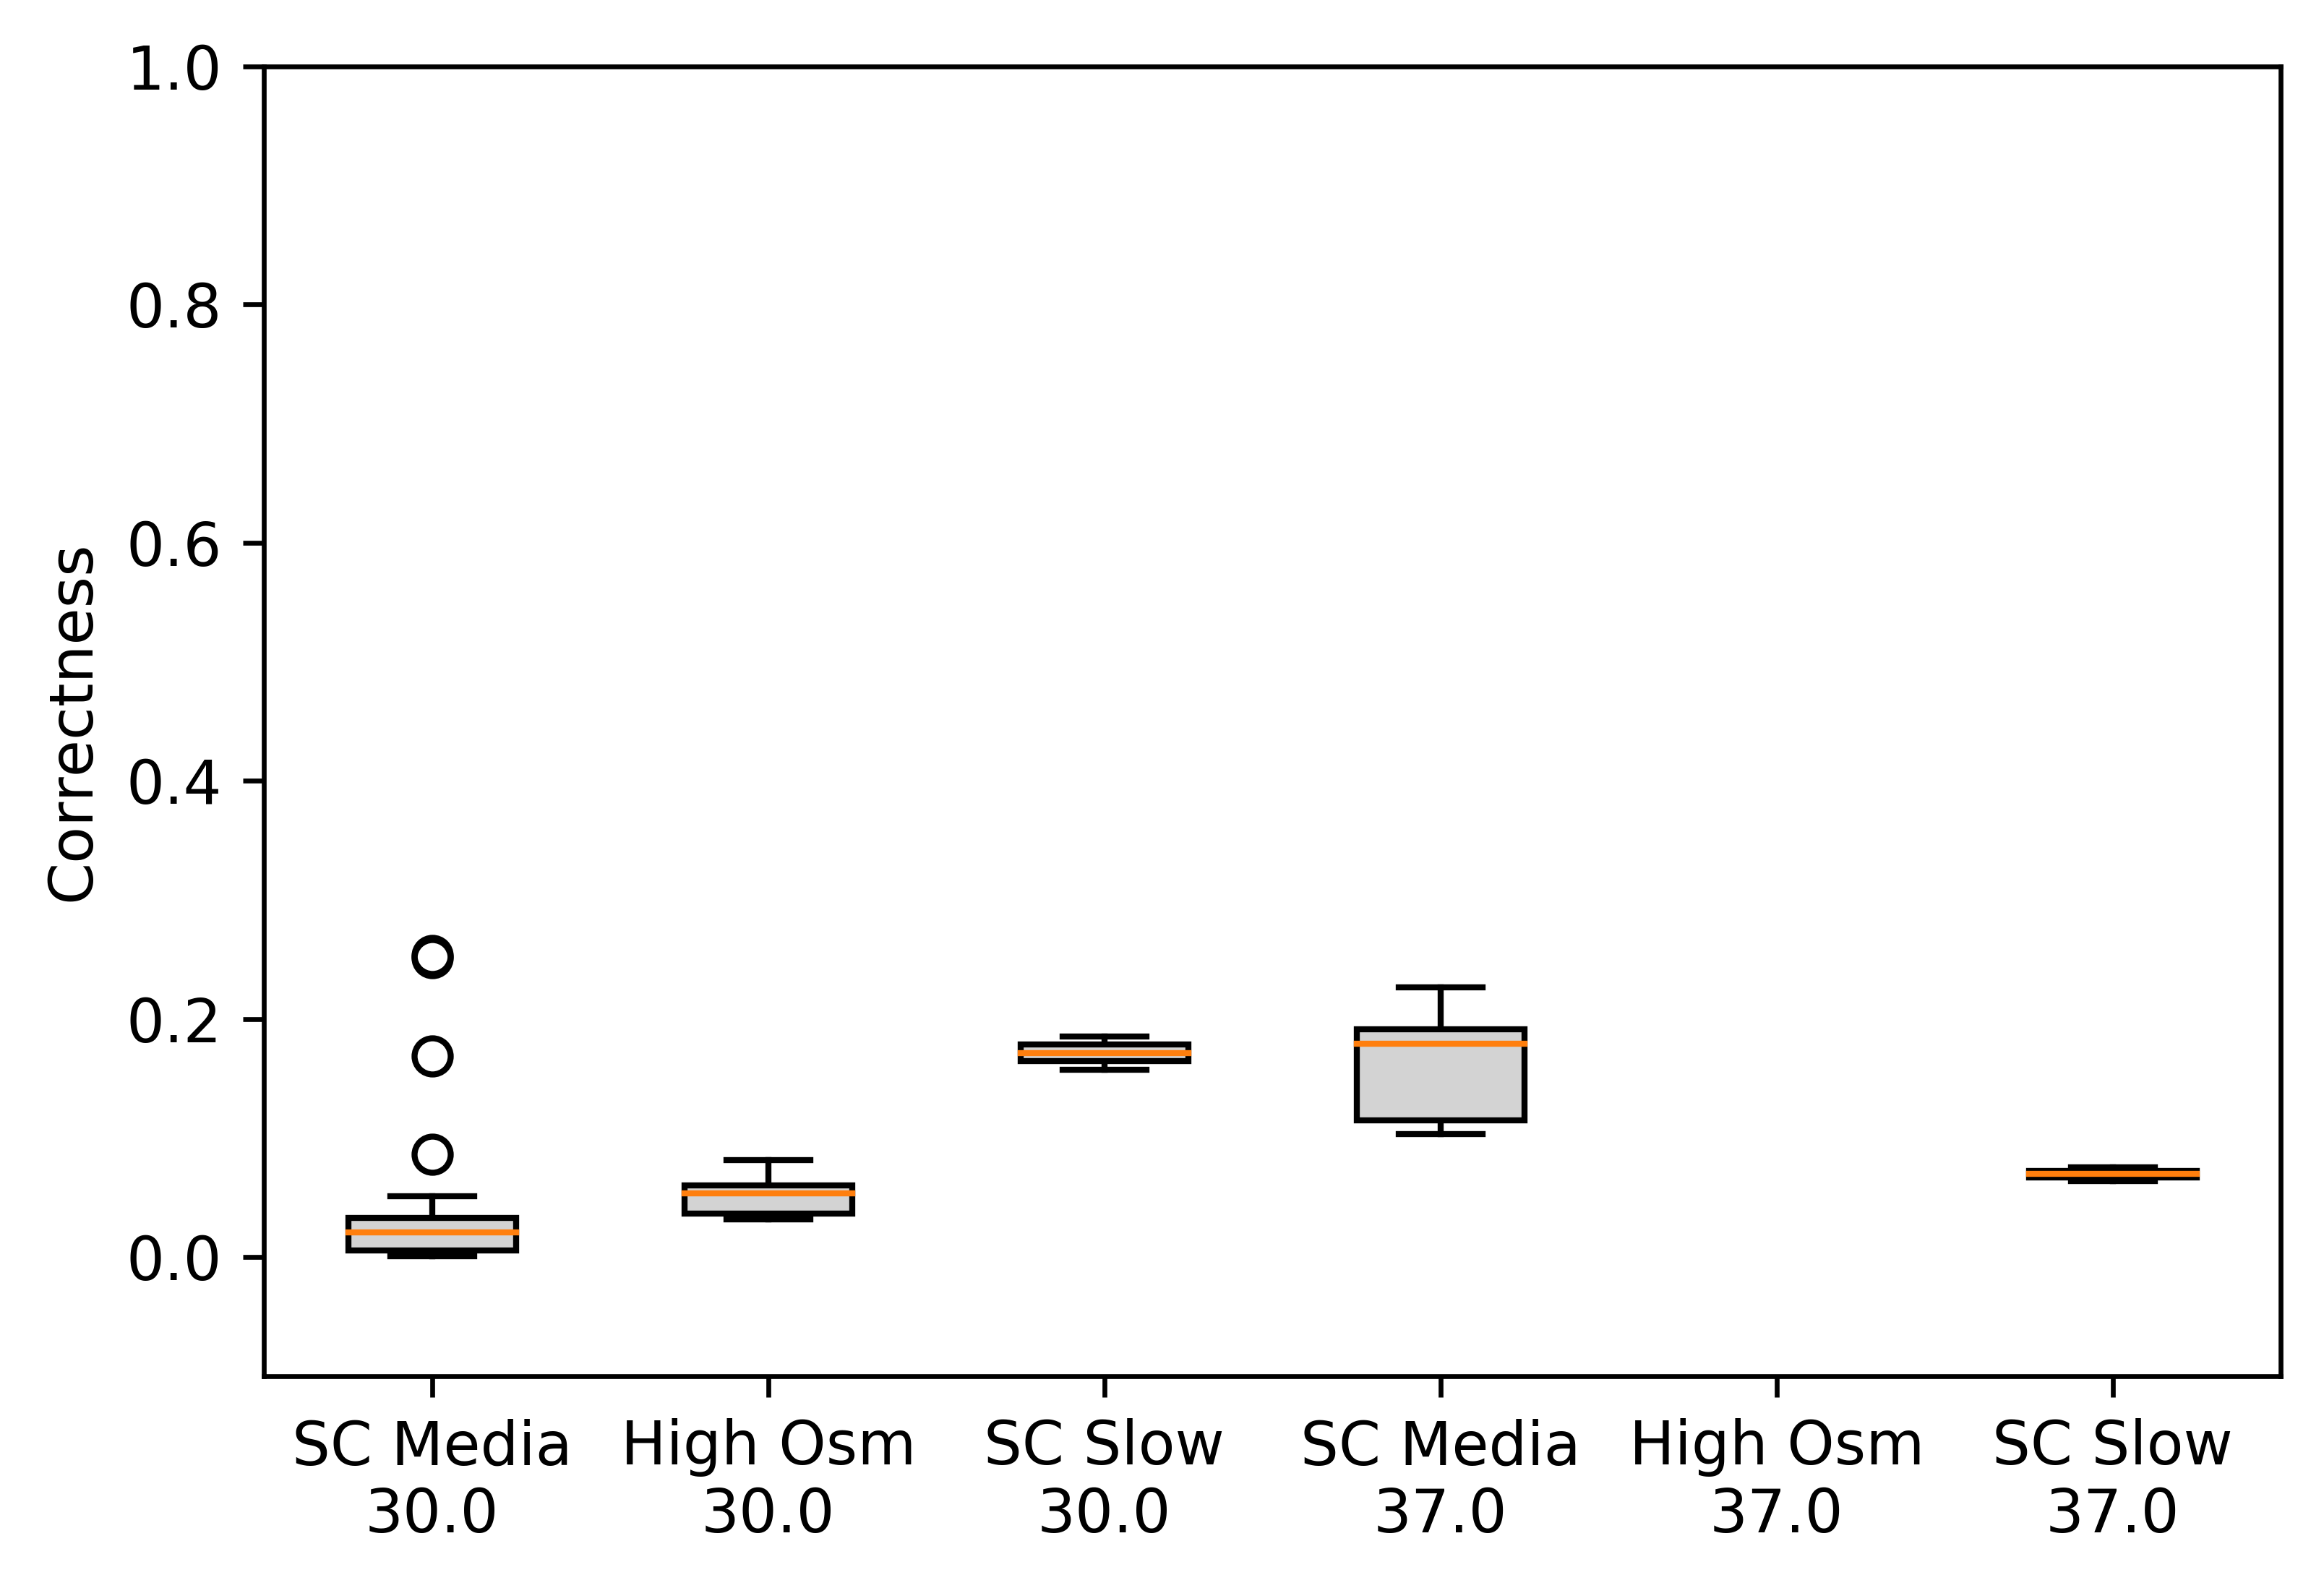

In [32]:
print("XOR")
medians = do_a_gate("XOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


XNOR
[('SC30', (0.22493021696549326, 0.040398659553035426)), ('OSM30', (0.008809244222057361, 0.003939613782183502)), ('SLOW30', (nan, nan)), ('SC37', (0.09092177982357862, 0.04066145606415812)), ('OSM37', (nan, nan)), ('SLOW37', (0.021631184716758137, 0.015295557398318485))]
[('SC30', (0.20331973138585077, 0.036517301763558475)), ('OSM30', (0.028087767488592975, 0.012561231488140487)), ('SLOW30', (nan, nan)), ('SC37', (0.04479814600523586, 0.020034339946733603)), ('OSM37', (nan, nan)), ('SLOW37', (0.018489745480078264, 0.013074224411376656))]


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning

Percent of threshold median at least 0.0 below classifier median: 0.75.
Percent of threshold median above classifier median: 0.25.


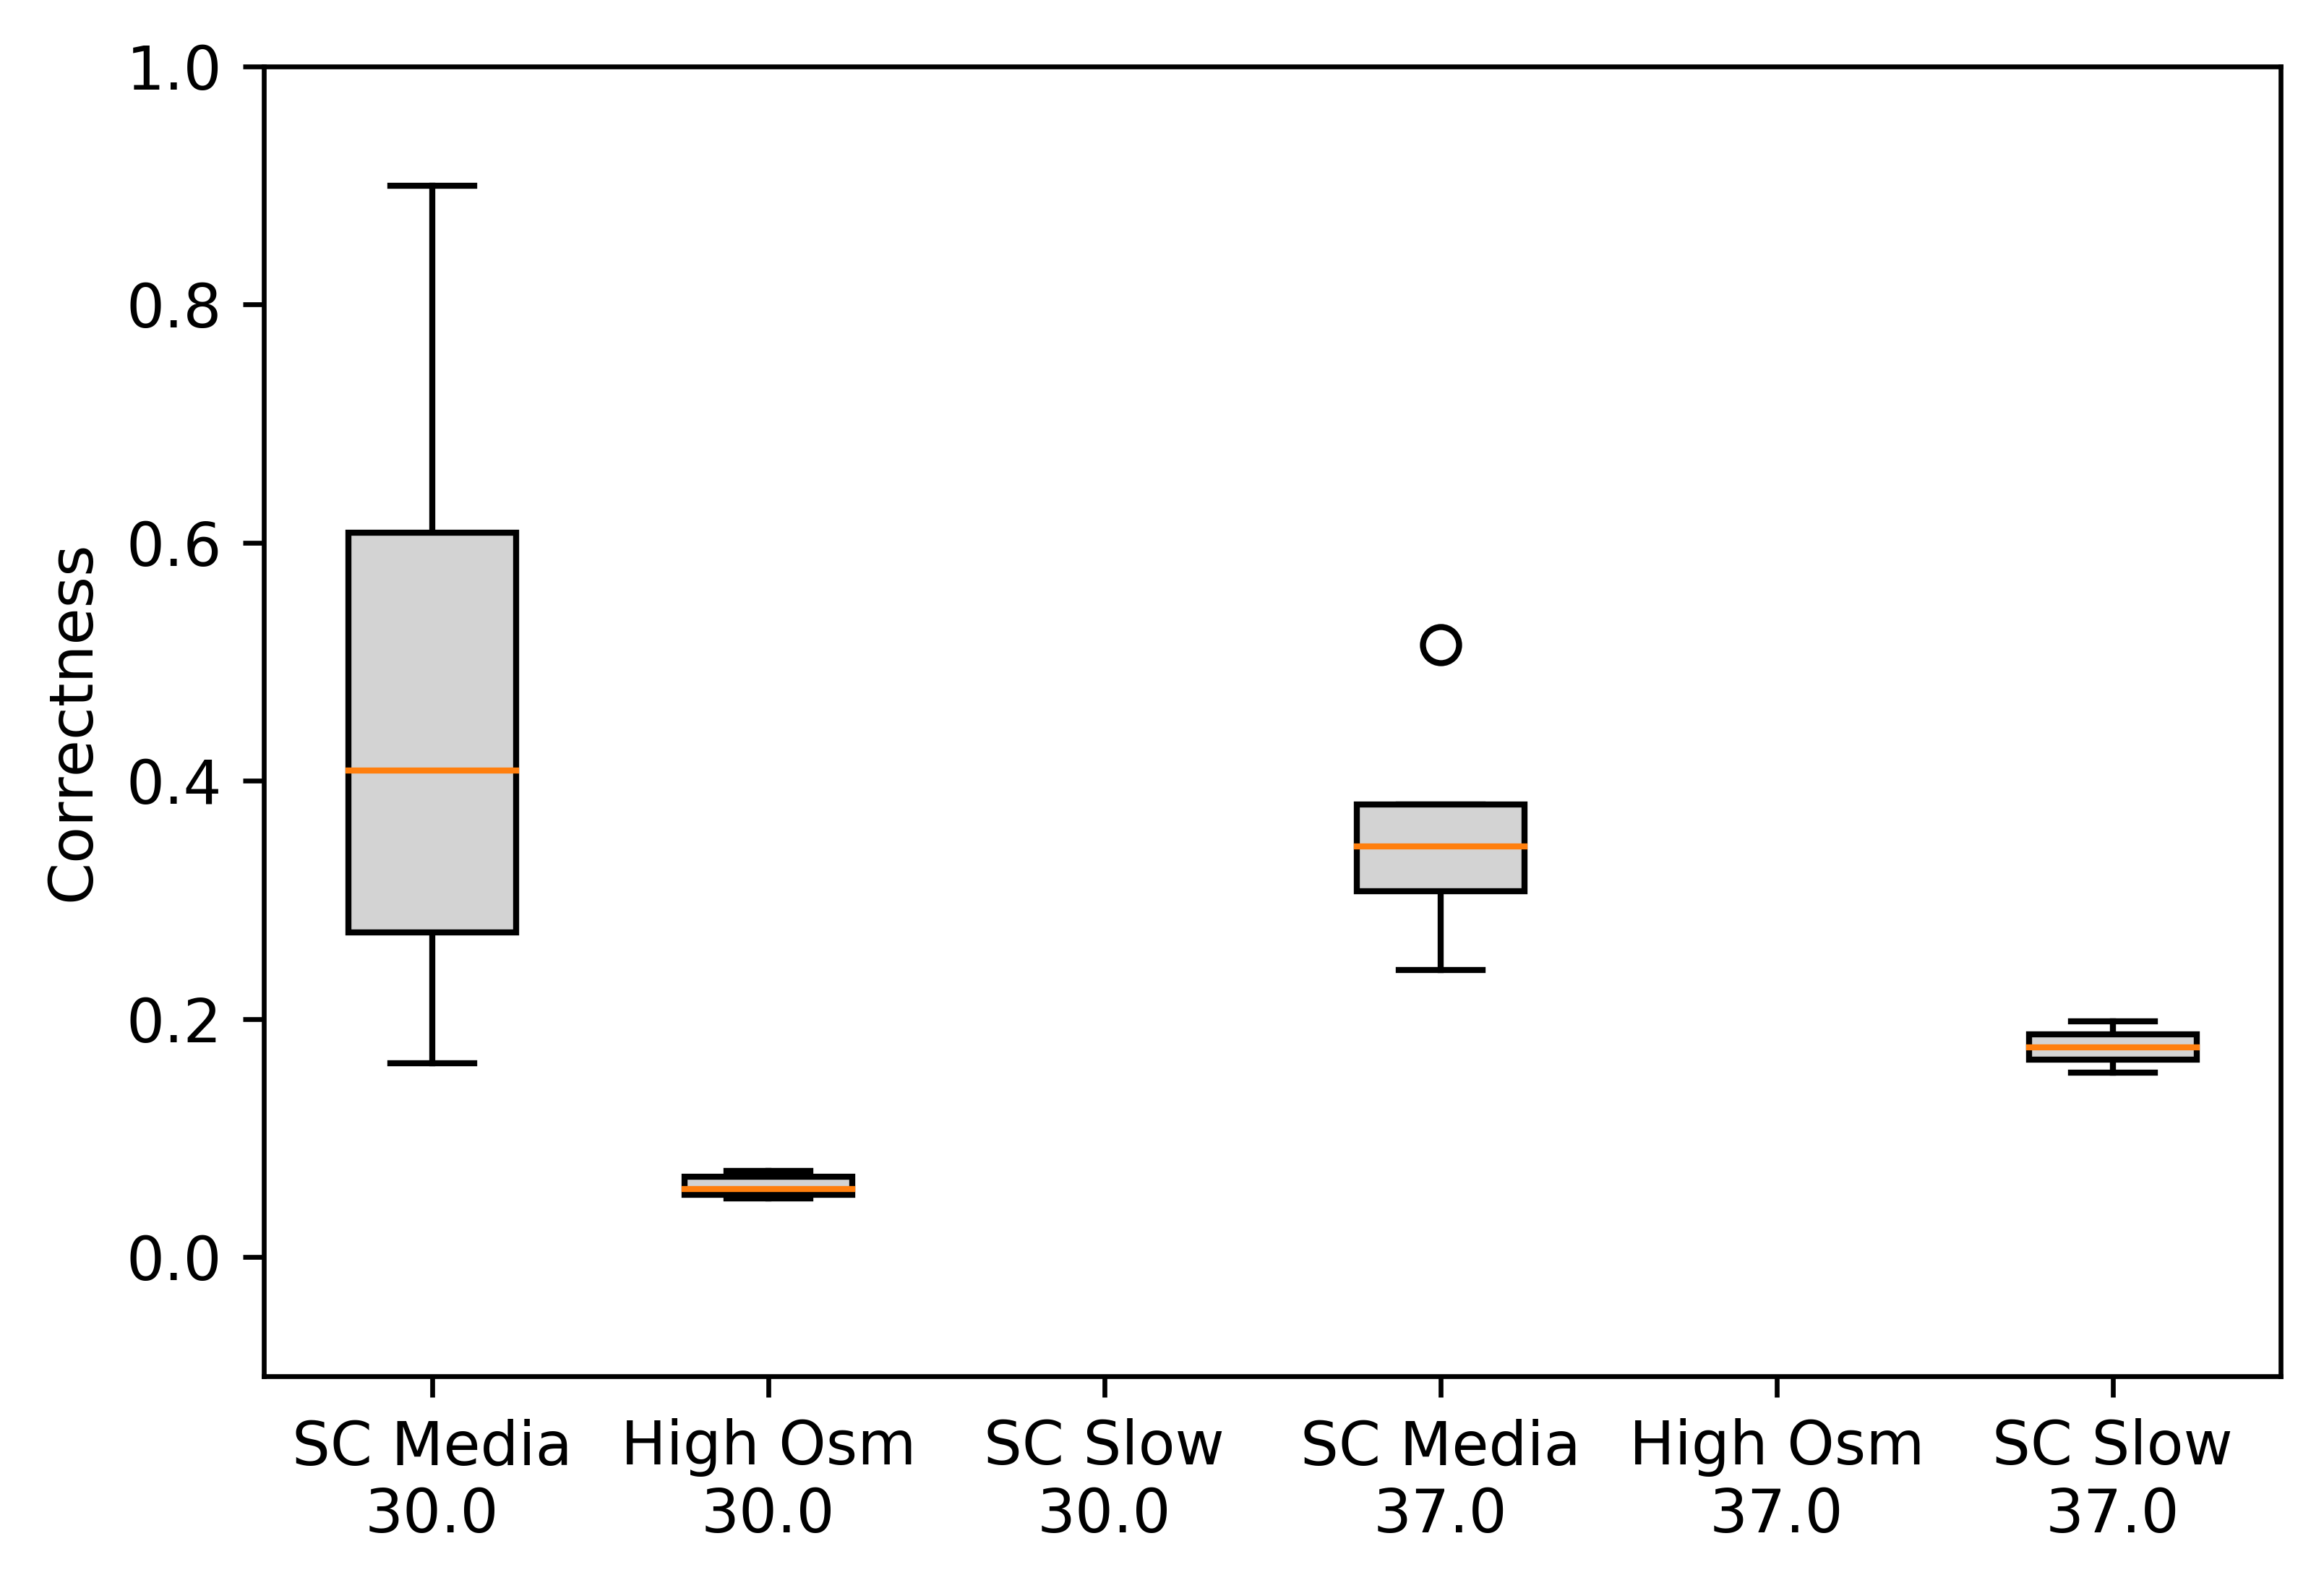

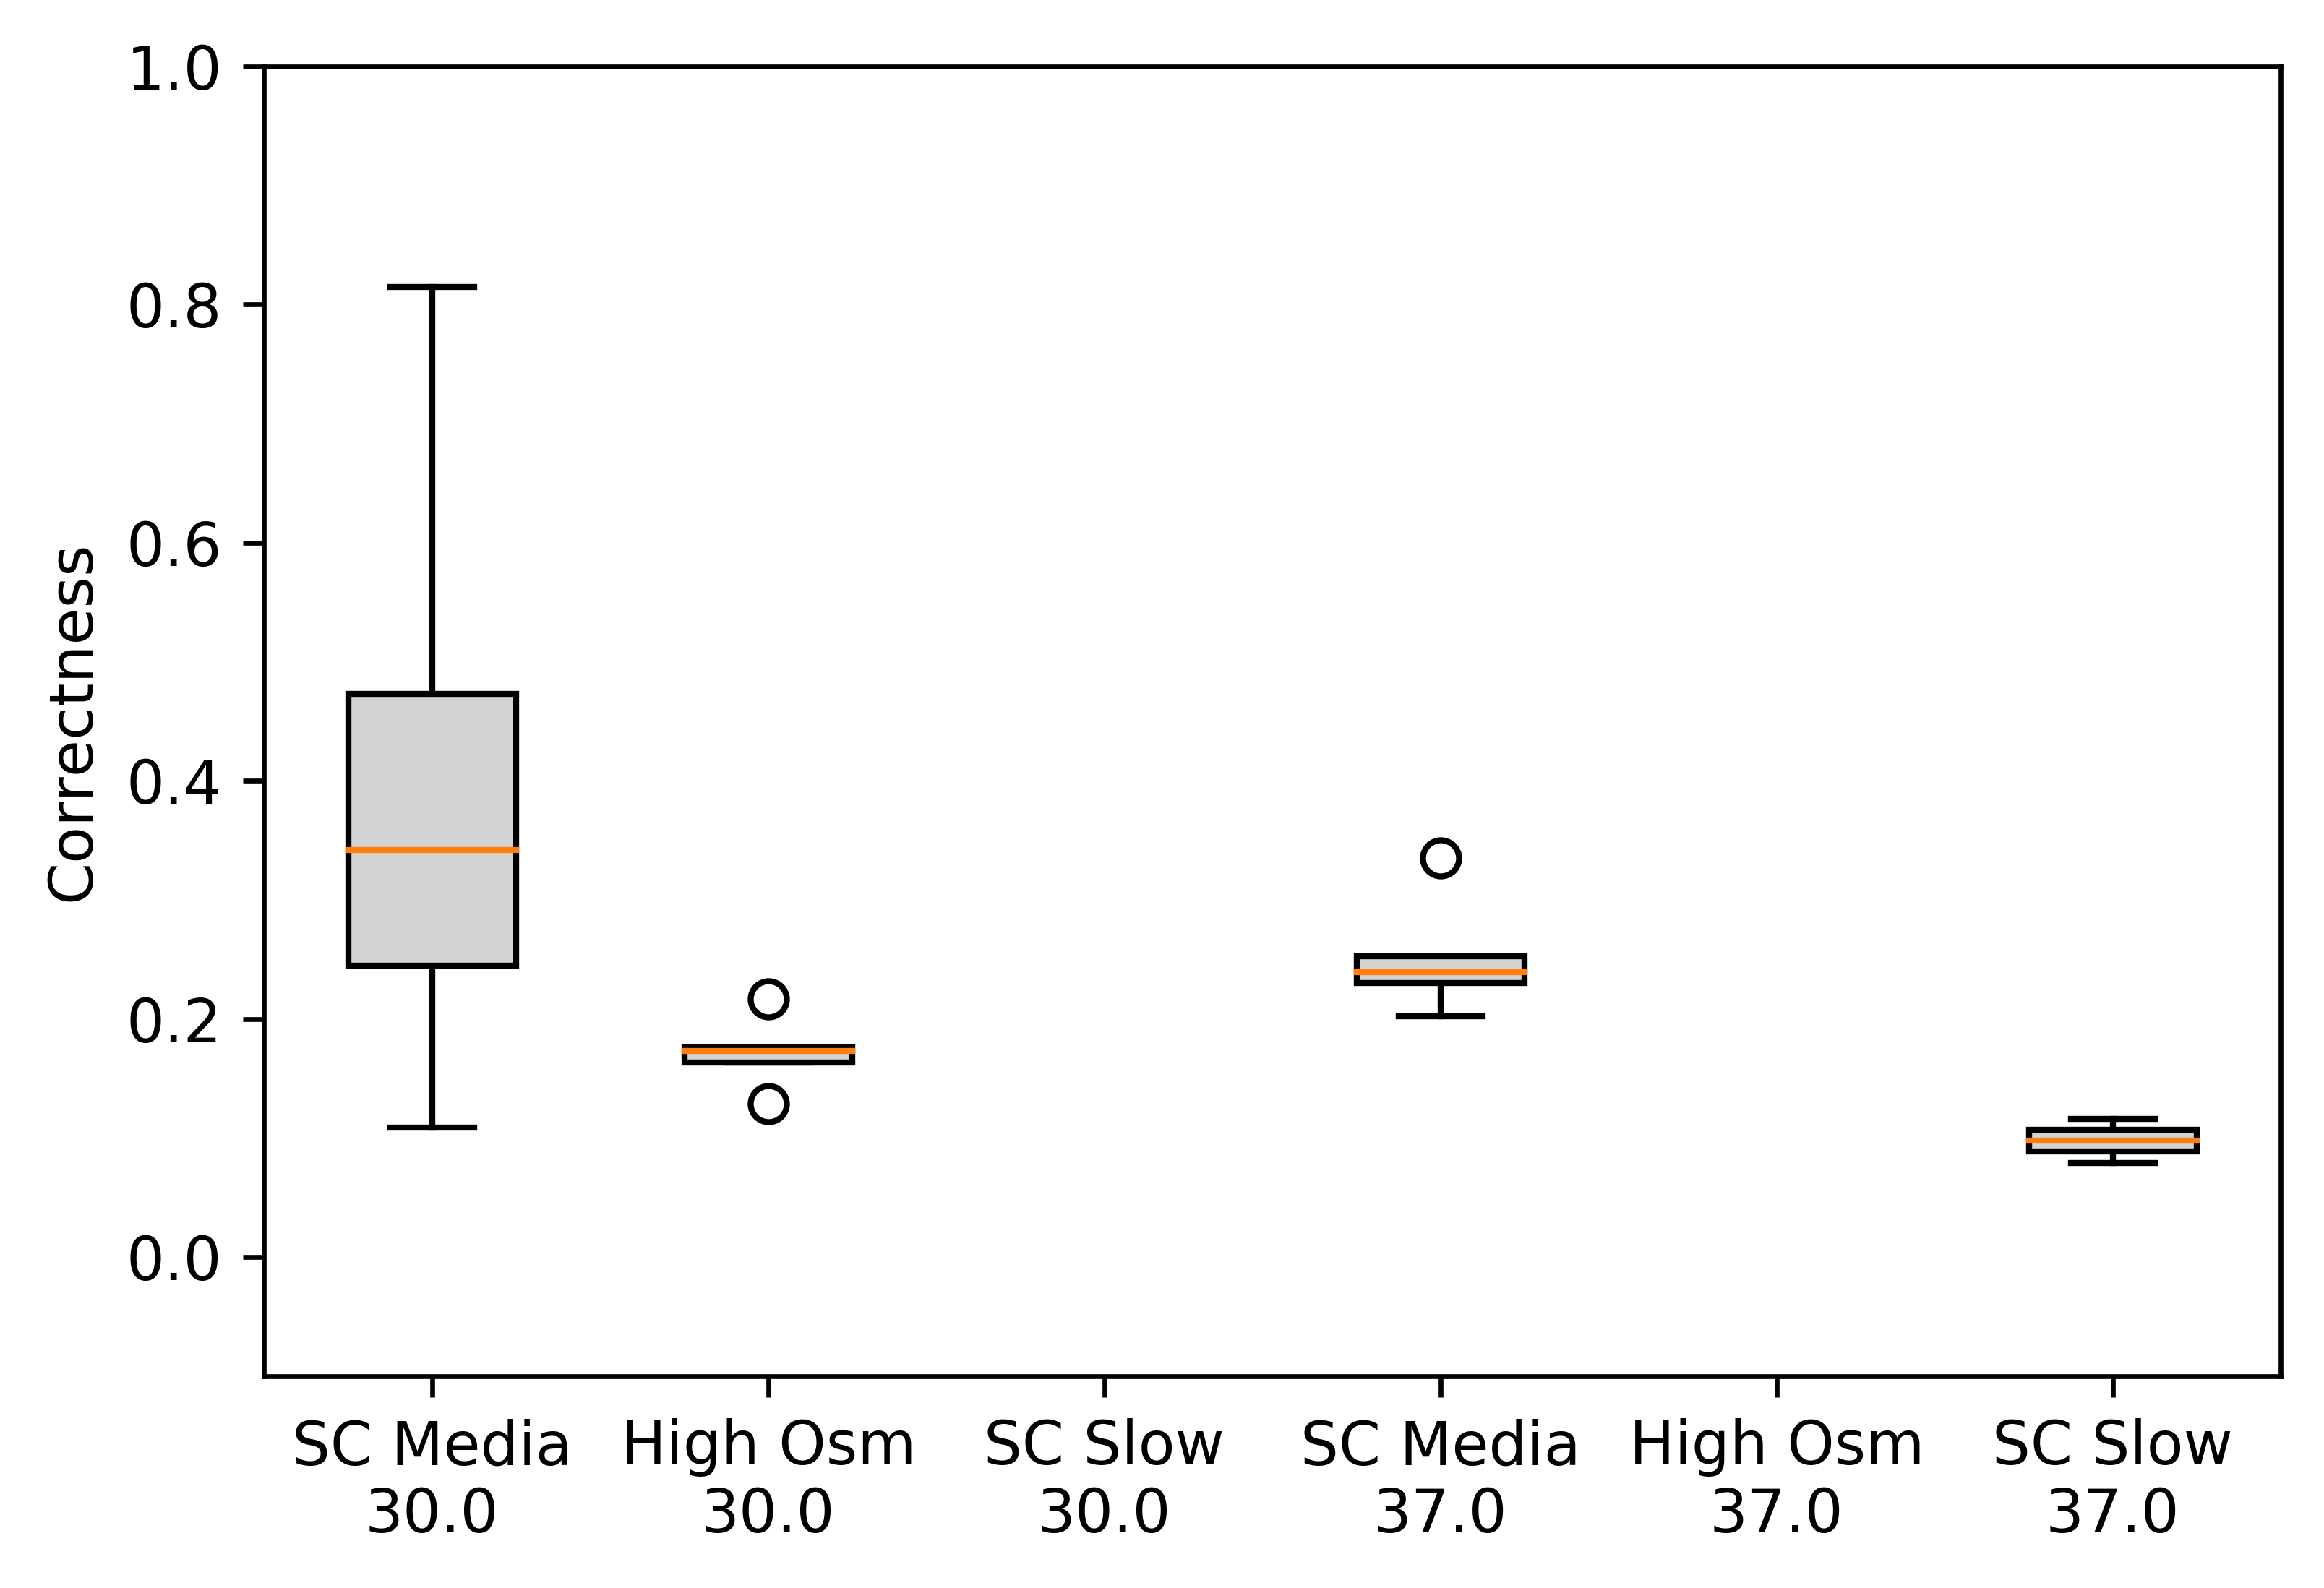

In [33]:
print("XNOR")
medians = do_a_gate("XNOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))
